# Project part 1

In [1]:
# Import libraries
import glob
import pandas as pd
import numpy as np
import calendar
from datetime import datetime
pd.options.mode.chained_assignment = None 
import requests
from difflib import SequenceMatcher
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
import scipy
import os
import json
import folium
import seaborn
import matplotlib.pyplot as plt
from branca.colormap import linear
import branca.colormap as cm
from IPython.display import HTML

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider

## Preparing data

The data we use is listed on Swiss open data. The actual data and further desciptions are given on Open Data Zurich. For the project we consider the following data sets:

1) "Umzüge nach Stadtquartier, Geschlecht, Altersgruppe und Zivilstand, seit 1993" lists all moves between districts of the City of Zurich since 1993 by district, gender, age group and marital/civil status

2) "Zuzüge nach Zuzugsort, Stadtquartier, Geschlecht, Altersgruppe und Zivilstand, seit 1993" lists all moves into districts of the City of Zurich from outside since 1993 by place of origin, district, gender, age group and marital/civil status

3) "Wegzüge nach Wegzugsort, Stadtquartier, Geschlecht, Altersgruppe und Zivilstand, seit 1993" lists all moves out of districts of the City of Zurich from outside since 1993 by place of origin, district, gender, age group and marital/civil status

4) "Bevölkerung nach Stadtquartier, Herkunft, Geschlecht und Alter, seit 1993" lists all people living in districts by age, Swiss/foreigh and gender

5) "Bevölkerung nach Nationalität und Stadtquartier, seit 1993" lists number of people and nationalities in each district

6) "Bevölkerung und Anzahl Nationalitäten nach Stadtquartier, seit 1993" lists number of people and nationalities in each district

7) "Median-Vermögen steuerpflichtiger natürlicher Personen nach Jahr, Steuertarif und Stadtquartier" lists the quartile of taxable wealth per tax class for each district

8) "Median-Einkommen steuerpflichtiger natürlicher Personen nach Jahr, Steuertarif und Stadtquartier" lists the quartile of income per tax class for each district

In [2]:
ZH_within_1993_URL = 'https://data.stadt-zuerich.ch/dataset/bev_umzuege_jahr_quartier_ag_zivilstand/resource/212bc17b-25ac-4c1c-bef0-cedfddaaceb7/download/bev355od3556.csv'

ZH_in_1993_URL = 'https://data.stadt-zuerich.ch/dataset/bev_zuz_jahr_quartier_ag_zivilstand/resource/aa5020b5-4e21-4c06-897c-478e08277419/download/bev351od3512.csv'

ZH_out_1993_URL = 'https://data.stadt-zuerich.ch/dataset/bev_wegz_jahr_quartier_ag_zivilstand/resource/7462b6b8-100a-4782-a12b-6649a9f1c249/download/bev352od3522.csv'

ZH_population_1993_URL = 'https://data.stadt-zuerich.ch/dataset/6f8b5279-998b-4000-a5a4-e3addf10c49e/resource/f2384262-e8c8-4d04-91fa-3cbf15e2b673/download/bev390od3903.csv'

ZH_nationalities_1993_URL = 'https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_quartier_nationalitaet/resource/10b83df1-b247-467d-a3cb-0b389a758e1a/download/bev336od3361.csv'

ZH_number_nation_1993_URL = 'https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_anz_nationen_quartier/resource/634b6e5a-7143-4eab-9f5d-fb75dd92d5da/download/bev336od3363.csv'

ZH_median_wealth_1999_URL = 'https://data.stadt-zuerich.ch/dataset/f8c9ebd3-629b-450b-9a61-244bcf7ec44b/resource/e4d02782-e6f8-4138-9b41-ac8946ee3327/download/wir100od1004.csv'

ZH_median_income_1999_URL = 'https://data.stadt-zuerich.ch/dataset/63e0caf8-a46c-4aec-ad13-d1803d448f9c/resource/0c67045f-ce8d-4dff-b1e3-2263524f96f4/download/wir100od1007.csv'

#Defining the data frames
ZH_within_df=pd.read_csv(ZH_within_1993_URL)
ZH_in_df=pd.read_csv(ZH_in_1993_URL)
ZH_out_df=pd.read_csv(ZH_out_1993_URL)
ZH_population_df=pd.read_csv(ZH_population_1993_URL)
ZH_nationalities_df=pd.read_csv(ZH_nationalities_1993_URL)
ZH_number_nation_df=pd.read_csv(ZH_number_nation_1993_URL)
ZH_median_wealth_df=pd.read_csv(ZH_median_wealth_1999_URL)
ZH_median_income_df=pd.read_csv(ZH_median_income_1999_URL)

ZH_in_df = pd.read_csv('Data/ZH_in.csv')
ZH_within_df = pd.read_csv('Data/ZH_within.csv')
ZH_out_df = pd.read_csv('Data/ZH_out.csv')

all_frames = [ZH_in_df, ZH_within_df, ZH_out_df]
ZH_popul = pd.read_csv('Data/ZH_popul_Total.csv')
ZH_popul_CH = pd.read_csv('Data/ZH_popul_CH.csv')

In [3]:
# Grouping all frames
all_frames = [ZH_in_df, ZH_within_df, ZH_out_df, ZH_population_df,
              ZH_nationalities_df, ZH_number_nation_df, 
              ZH_median_wealth_df, ZH_median_income_df]

# Translating column names for individual frames
# Stadtquartier translated as district
# Kreis translated as council
ZH_within_df.columns = ['Year', 
                       'district_from_code', 'district_from_name', 'council_from_code',
                       'district_to_code', 'district_to_name', 'council_to_code',
                       'age_group_code', 'age_group', 'gender', 
                       'marital_code', 'marital_status', 'Total']

#Bezirk translated as county
ZH_in_df.columns = ['Year', 
                    'county_from_code', 'county_from_name', #foreigner for non-Swiss
                    'canton_from_code', 'canton_from_name', #foreigner for non-Swiss
                    'country_from_code', 'country_from_name', 
                    'subcontinent_from_code', 'subcontinent_from_name', 
                    'continent_from_code', 'continent_from_name',
                    'district_to_code', 'district_to_name', 'council_to_code',
                    'age_group_code', 'age_group', 'gender', 
                    'marital_code', 'marital_status', 'Total']

#Bezirk translated as county here
ZH_out_df.columns = ['Year', 
                    'county_to_code', 'county_to_name', #foreigner for non-Swiss
                    'canton_to_code', 'canton_to_name', #foreigner for non-Swiss
                    'country_to_code', 'country_to_name', 
                    'subcontinent_to_code', 'subcontinent_to_name', 
                    'continent_to_code', 'continent_to_name',
                    'district_from_code', 'district_from_name', 'council_from_code',
                    'age_group_code', 'age_group', 'gender', 
                    'marital_code', 'marital_status', 'Total']

ZH_population_df.columns = ['Year', 'district_code', 'district_code2', 'district_name',
                            "age", "age2", "age_group5_code", "age_group5",
                            "CH_nonCH", "CH_nonCH_code", "gender_code", "gender", "Total"]

# Difference between nation_hist and nation exist in case where nations split or united
# e.g. "Serbien, Montenegro, Kosovo" vs "Serbien" (2006), "Montenegro"(2006/07), "Kosovo"(2008)
ZH_nationalities_df.columns = ['Year', 'district_code', 'district_code2', 'district_name',
                             'nation_hist_code', 'nation_hist_name', 'nation_code', 'nation_name',
                             'subcontinent_code', 'subcontinent_name',
                             'continent_code', 'continent_name', 'Total']

ZH_number_nation_df.columns = ['Year', 'district_code', 'district_code2', 'district_name',
                       'Total_pop', 'Total_nat']

ZH_median_wealth_df.columns = ['Year', 'district_code', 'district_name', 
                               'tax_code', 'tax_class', 
                               'tax_wealth_p50', 'tax_wealth_p25', 'tax_wealth_p75']
# Kreis translated as borough, borough = set of districts
ZH_median_wealth_df.columns = ['Year', 'borough_code', 'borough_name', 
                               'tax_code', 'tax_class', 
                               'tax_wealth_p50', 'tax_wealth_p25', 'tax_wealth_p75']

## Replacing the most used German terminology to English terms.

We create dictionaries for the most common terms that appear in the data. Thsi will allow English speaking readers and group members to work with the data.

Comment: At this stage we don't translate all the country names, as we expect that names are rarely called.We may do their translation using a dictionary at a later stage.

In [4]:
# We make a dictionary of distionary to translate individual categories

# Sample code
# cleanup_nums = {"num_doors":     {"four": 4, "two": 2},
#                 "num_cylinders": {"four": 4, "six": 6, "five": 5, "eight": 8,
#                                   "two": 2, "twelve": 12, "three":3 }}
# obj_df.replace(cleanup_nums, inplace=True)
# obj_df.head()

translation = {"marital_status" : {"Ledig" : "Single", "Verheiratet" : "Married", 
                                    "Geschieden" : "Divorced", "Verwitwet" : "Widow", 
                                    "In eingetragener Partnerschaft" : "Registered partnership", 
                                    "Aufgelöste Partnerschaft" : "Disolved partnership", 
                                    "Unbekannt" : "Unknown"},
               "tax_class" :       {"Grundtarif" : "base rate",
                                    "Verheiratetentarif" : "couple rate",
                                    
                                    "Einelternfamilientarif" : "single parent family rate"},
               "gender" :          {"W":"F"}}
translation_global = {"Ausland" : "Foreign", "Ausländer/in" : "Foreign",
                      "Schweizer/in" : "Swiss", "Unbekannt" : "Unknown",
                      "Unzuteilbar" : "Undetermined", "100 u. älter" : "99+"}

for frame in all_frames:
    frame.replace(translation, inplace=True)
    frame.replace(translation_global, inplace=True)



## Saving the data frames to files in a local drive

We save that data locally, for quicker offline access.

In [5]:
ZH_in_df.to_csv('Data/ZH_in.csv', encoding='utf-8', index = False)

ZH_out_df.to_csv('Data/ZH_out.csv', encoding='utf-8', index = False)

ZH_within_df.to_csv('Data/ZH_within.csv', encoding='utf-8', index = False)

ZH_population_df.to_csv('Data/ZH_popul.csv', encoding='utf-8', index = False)

ZH_nationalities_df.to_csv('Data/ZH_nationalities.csv', encoding='utf-8', index = False)

ZH_number_nation_df.to_csv('Data/ZH_number_nation.csv', encoding='utf-8', index = False)

ZH_median_wealth_df.to_csv('Data/ZH_median_wealth.csv', encoding='utf-8', index = False)

ZH_median_income_df.to_csv('Data/ZH_median_income.csv', encoding='utf-8', index = False)



# Milesstone 2 

### Retrieving our data from the local drive

In [6]:
ZH_in_df = pd.read_csv('Data/ZH_in.csv')
ZH_within_df = pd.read_csv('Data/ZH_within.csv')
ZH_out_df = pd.read_csv('Data/ZH_out.csv')
ZH_popul = pd.read_csv('Data/ZH_popul.csv')
ZH_nationalities_df = pd.read_csv('Data/ZH_nationalities.csv')
ZH_nations_df = pd.read_csv('Data/ZH_number_nation.csv')

all_frames = [ZH_in_df, ZH_within_df, ZH_out_df, ZH_popul, ZH_nationalities_df, ZH_nations_df]

In [7]:
#ZH_in_df.head()

In [8]:
#ZH_out_df.head()

In [9]:
#ZH_within_df.head()

In [10]:
ZH_popul=ZH_popul.drop(['district_code2', 'age2','age_group5_code','gender_code', 'CH_nonCH_code'], axis=1)
ZH_popul.head()


Year  district_code district_name  age age_group5 CH_nonCH gender  Total
0  1993  11             Rathaus       0    0-4        Swiss    M      11   
1  1993  11             Rathaus       0    0-4        Swiss    F      8    
2  1993  11             Rathaus       0    0-4        Foreign  M      1    
3  1993  11             Rathaus       0    0-4        Foreign  F      6    
4  1993  11             Rathaus       1    0-4        Swiss    M      11

### Functions used in Milestone 2

In [11]:
# The function: df_subset_total
# df = data frame to be used
# retain_columns = list of columns that we retain, while all other columns are collapsed
# total_column = the name of the column with the values we wish to add up, e.g. 'Total' or 'count'
#
#Observe: the final dataframe contains the columns in retain_columns and the column 'Total'
#
# Definition:
def df_subset_total(df, retain_columns, total_column):
    output = pd.DataFrame({'Total' : df.groupby( retain_columns )[total_column].agg('sum')}).reset_index()
    return output;


#-------------------------------------------------------------------------------------------------------------

# The function: df_subset_percent
# df = data frame to be used
# selected_columns = list of selected columns for which we find maximum value for each possible combination, 
#                    remaining columns are displayed to identify criteria.
#                    Note: Apply df_subset_total first if we want to sum over certain columns first
# total_column = the name of the column with the values we wish to select maximum from, e.g. 'Total' or 'Value'
#

def df_subset_percent(df, retain_groups, percent_group, total_column):
    # create groupby_list by checking form retain_groups has
    if isinstance(retain_groups, str)==True:
        groupby_list = [retain_groups, percent_group]
    else:
        groupby_list = retain_groups + [percent_group]

    # Initial grouping (basically a sorted version of df)
    InitGroupby_df = df.groupby(groupby_list).agg({total_column: 'sum'}).reset_index()
    # Get the sum of values (count) for the "final group", append "_Sum" to it's column name to get "count_Sum",
    # and change it into a dataframe (.reset_index)
    SumGroup_df = df.groupby(retain_groups).agg({total_column: 'sum'}).add_suffix('_Sum').reset_index()
    # Merge the two dataframes
    Percents_df = pd.merge(InitGroupby_df, SumGroup_df)
    # Divide the two columns
    Percents_df["Percent of"+" "+percent_group] = Percents_df[total_column] / Percents_df[total_column+"_Sum"] * 100
    # Drop the extra _Sum column
    Percents_df.drop([total_column+"_Sum"], inplace=True, axis=1)
    output = Percents_df
    return output;


#-------------------------------------------------------------------------------------------------------------

# The function: df_subset_max
# df = data frame to be used
# selected_columns = list of selected columns for which we find maximum value for each possible combination, 
#                    remaining columns are displayed to identify criteria.
#                    Note: Apply df_subset_total first if we want to sum over certain columns first
# total_column = the name of the column with the values we wish to select maximum from, e.g. 'Total' or 'Value'
#
#Observe: The final result has exactly one row with each possible value permutation from selected_columns
#         In order to select the maximum from certain criteria we may wish to collapse some columns first 
#         with df_subset_total before finding the max
#
# Definition:

def df_subset_max(df, selected_columns, total_column):
    output = df[ df[total_column] == df.groupby( selected_columns)[total_column].transform(max) ]
    return output;


#-------------------------------------------------------------------------------------------------------------

# The function: df_select_values
# df = data frame to be used
# selected_column = name of column for which we want to select values
# value_list = list of values we want to view e.g. ['val1', val2', val3']
#
# Definition:

def df_select_values(df, selected_column, value_list):
    output = df[df[selected_column].isin(value_list)]
    return output;


## Total number of people

In [12]:
ZH_total_popul = df_subset_total(ZH_popul, 'Year', 'Total')#.set_index('Year')
#ZH_total_popul.head()

### Total number of people by feature

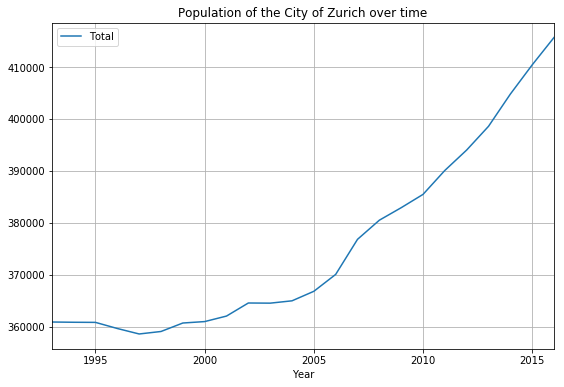

In [13]:
ZH_popul_Total = df_subset_total(ZH_popul, ['Year', 'district_name'], 'Total')
ZH_popul_Total.set_index('Year').to_csv('Data/ZH_popul_Total.csv', encoding='utf-8', index = True)
ZH_popul_Total.reset_index()
ZH_popul_gender = df_subset_total(ZH_popul, ['Year', 'district_name', 'gender'], 'Total')
ZH_popul_gender.set_index('Year').to_csv('Data/ZH_popul_gender.csv', encoding='utf-8', index = True)
ZH_popul_CH = df_subset_total(ZH_popul, ['Year', 'district_name', 'CH_nonCH'], 'Total')
ZH_popul_CH.set_index('Year').to_csv('Data/ZH_popul_CH.csv', encoding='utf-8', index = True)


ZH_total_popul.plot.line(x='Year', grid=True, figsize=(9,6), title='Population of the City of Zurich over time')

We can see that the population has grown, first at a rate of 1250 per year from 1998-2006 and then at a steady rate of around 4500 per year since 2006. That is equivalent to around 1.25% per year.

### Analysing changes in moves over time

#### Annual total number of moves and per 100 people of the population

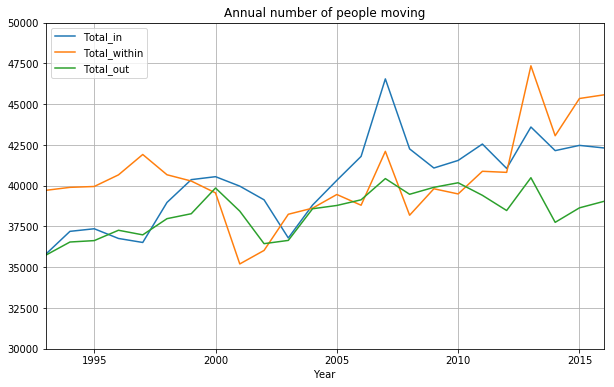

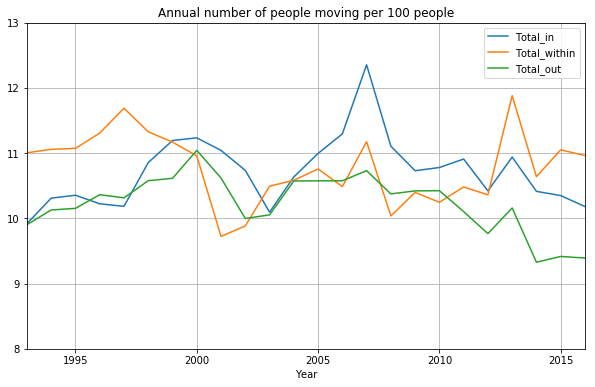

In [14]:
ZH_in_annual = df_subset_total(ZH_in_df, 'Year', 'Total').set_index('Year')
ZH_in_annual.columns = ['Total_in']
ZH_within_annual = df_subset_total(ZH_within_df, 'Year', 'Total').set_index('Year')
ZH_within_annual.columns = ['Total_within']
ZH_out_annual = df_subset_total(ZH_out_df, 'Year', 'Total').set_index('Year')
ZH_out_annual.columns = ['Total_out']
ZH_moves_totals = pd.concat([ZH_in_annual, ZH_within_annual, ZH_out_annual], axis=1 )
ZH_moves_totals.plot.line(title='Annual number of people moving', grid=True, ylim = (30000,50000),figsize=(10,6) )

ZH_total_popul_yearindex=ZH_total_popul.set_index('Year')
# Representing moves against population per 100
ZH_moves_per_100 = ZH_moves_totals[['Total_in', 'Total_within', 'Total_out']].div(ZH_total_popul_yearindex['Total'], axis=0)*100

ZH_moves_per_100.plot.line(title='Annual number of people moving per 100 people', grid=True, ylim = (8,13),figsize=(10,6) )

**Observations:** 

1) All three movements are roughly of equal scale. In particular, there are as many people moving between districts as either move in from outside or move out to elsewhere.

2) The long term trend for the total number in all three groups is up. However when we adjust against the current population we see that per 100 ZH_in and ZH_out slightly decrease in the last decade (even ignoring 2007 spike). Only per 100 ZH_within has gone up in the last 5 years.

The long term views for any of the movements show no clear change compared to the annual fluctuations. ZH_within has just recovered the dip from 11% to 10% has just been recovered.

3) According to these figures, from 2005 onwards we have an on-going net gain (ZH_in - ZH_out) of 2000-5000 people per year from 2005 onwards. In the interval [2006-2016] the overall population increase on average by 4000 people. However, our current analysis ignores births and deaths for Zurich!

4) If we have a year-to-year change of more than 2500, say, then we consider this a sharp drop or sharp rise. If a sharp rise is followed by a sharp drop, and the corrected net change would not be classified as sharp, then we consider it a spike or dip.

Following these notions we observe: 

ZH_in: We have a dip in 2003 and spike in 2007. 2013 appears to be due to general fluctuations.

ZH_within: We have a sharp drop in for 2001 (wider dip 2001 and 2002) and spikes in 2007 and 2013. 

ZH_out: We have a wider dip in 2002 and 2003. 2013 appears to be due to general fluctuations.


**Questions and tasks:** 

Do the dips around 2002 and the spikes in 2007 and 2013 result from certain subsets of the population? That is to say: Are there subsets for which these charcateristics appear and others for which they are not noticable? 

Was the change for ZH_in caused by Swiss people or by an increase for a specific group of foreigners?

Are these general changes reflected across all districts, too? Or do they vary by districts?

**Task:** 

Data should show which districts grew in number and in relative terms (expect inner city to have few extra buildings). Allow us to compare movement figures against base population.

### An observation

The shape of the graph for people moving to Zurich matches the shape of the Swiss Performance index (SPI) between 1995 and 2010 --- picture below. This suggest that the performance of the economy as tracked by the SPI influences the attraction for people to move to Zurich.

The spikes and dips observed in the othe two moving groups coincide with those of the SPI. However the overall profile matches less. 


### The percentage of women (the gender gap)

We analyse the ratio between men and women. First we look at the overall population and then we look at the ratios for people moving to, within and away from Zurich.

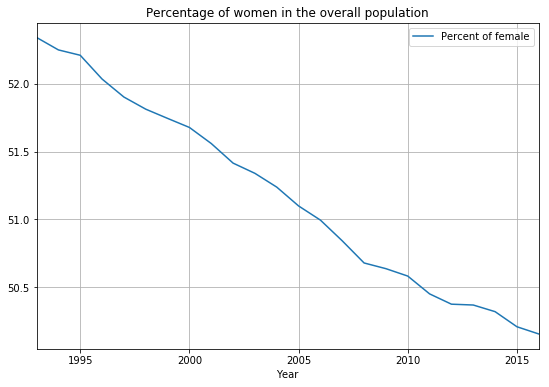

In [15]:
ZH_gender_percent = df_subset_percent(ZH_popul, ['Year'], 'gender', 'Total')
ZH_Female_percent =ZH_gender_percent[ZH_gender_percent['gender']=="F"]
ZH_Female_percent.rename(columns={'Percent of gender': 'Percent of female'}, inplace=True)

ZH_Female_percent.plot.line(x='Year', y='Percent of female', grid=True, figsize=(9,6), title='Percentage of women in the overall population')

We can see that the percentage of women has steadily declined from 52.5% to almost 50%. Hence in the overall population of Zurich the gender gap was in favour of women and has now closed.

#### Annual number of moves by gender

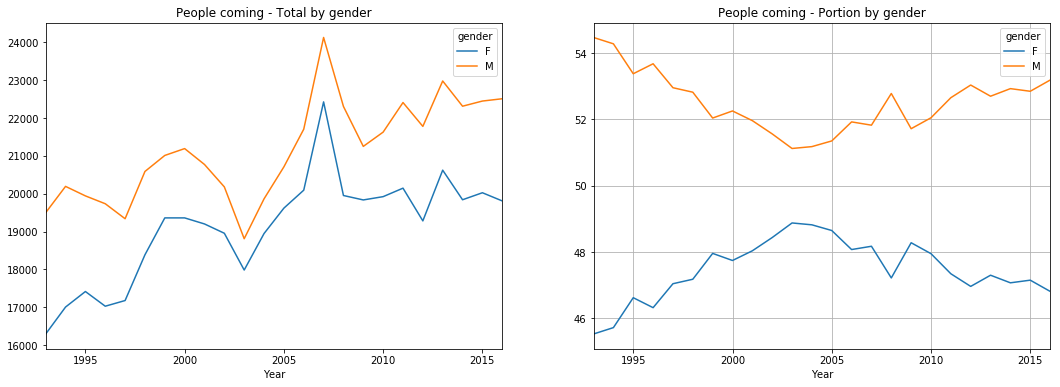

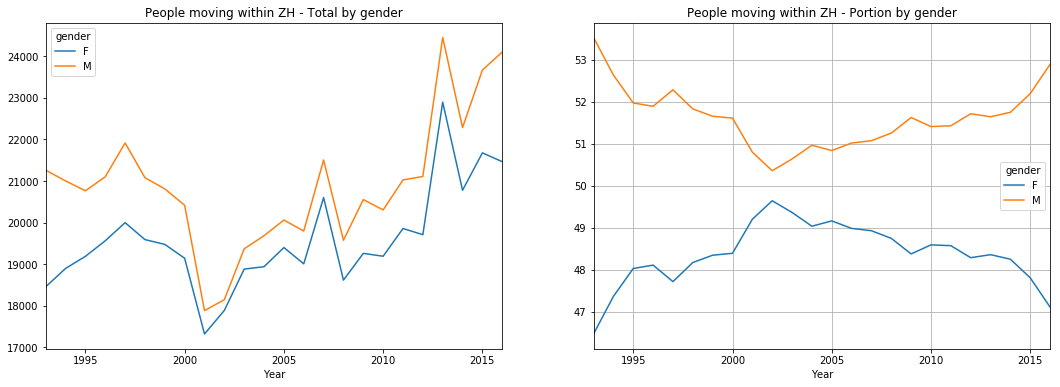

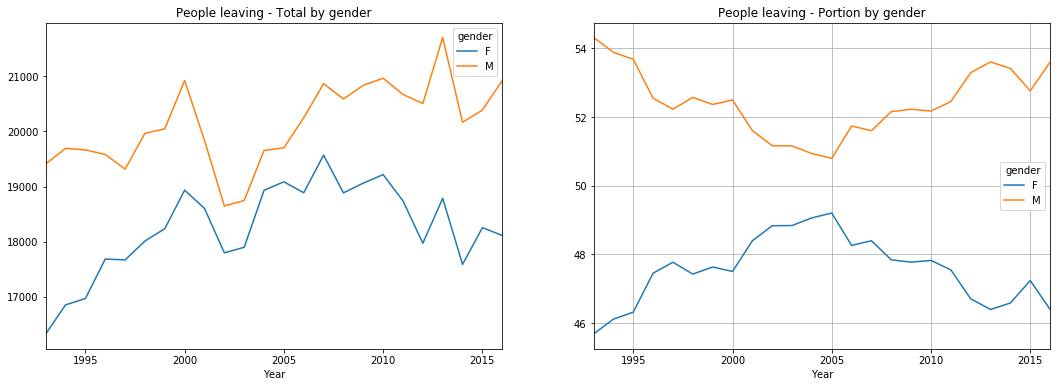

In [16]:
df_in = df_subset_total(ZH_in_df, ['Year', 'gender'], 'Total')
ZH_in_annual_by_gender_percent = df_subset_percent(df_in, 'Year', 'gender', 'Total')

fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1 = df_in.pivot(values='Total', index='Year',columns='gender')
table1.plot.line(ax=axes[0], title='People coming - Total by gender', stacked=False)

table2 = ZH_in_annual_by_gender_percent.pivot(values='Percent of gender', index='Year',columns='gender')
table2.plot.line(ax=axes[1], title='People coming - Portion by gender', grid=True)


df_within = df_subset_total(ZH_within_df, ['Year', 'gender'], 'Total')
ZH_within_annual_by_gender_percent = df_subset_percent(df_within, 'Year', 'gender', 'Total')


fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1 = df_within.pivot(values='Total', index='Year',columns='gender')
table1.plot.line(ax=axes[0], title='People moving within ZH - Total by gender', stacked=False)

table2 = ZH_within_annual_by_gender_percent.pivot(values='Percent of gender', index='Year',columns='gender')
table2.plot.line(ax=axes[1], title='People moving within ZH - Portion by gender', grid=True)


df_out = df_subset_total(ZH_out_df, ['Year', 'gender'], 'Total')
ZH_out_annual_by_gender_percent = df_subset_percent(df_out, 'Year', 'gender', 'Total')

fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1 = df_out.pivot(values='Total', index='Year',columns='gender')
table1.plot.line(ax=axes[0], title='People leaving - Total by gender', stacked=False)

table2 = ZH_out_annual_by_gender_percent.pivot(values='Percent of gender', index='Year',columns='gender')
table2.plot.line(ax=axes[1], title='People leaving - Portion by gender', grid=True)


**Observations:** 

The majority of women in the overall population is not reflected at all in the data for people moving. All three scenarios show a clear gender gap favouring men. This is no surprise for people moving to Zurich, as their profile should not be determined by the number of women, but instead by factors outside Zurich. However, we would expect that the number of women living in Zurich has an effect on how many move within and away form Zurich over time. This does not appear to be the case as the profiles are similar in all 3 scenarios.

**Conclusion:** 

We can see that women are far less likely to move than men. Men are more 'nomadic', while women stay for longer in one place.

**Observations of the gender profiles for the moving groups:** 

The **absolute numbers** per gender reflect those of the overall numbers of people moving.

ZH_in: We have a dip in 2003 and spike in 2007. 2013 appears to be due to general fluctuations.

ZH_within: We have a sharp drop in for 2001 (wider dip 2001 and 2002) and spikes in 2007 and 2013. 

ZH_out: We have a wider dip in 2002 and 2003. 2013 appears to be due to general fluctuations.

We observe that in all three settings the **gender gap** narrows by 6 percentage points (from 7-8pp to 1-2pp) 

Moreover in each case the dips around 2001-2003 happen a year befoer on at the same time as the narrowest gender gap and they mark a turning point after which the gap contniuoulsy widens again in all settings.

Note that in contrast the spikes of 2007 and 2013 are not reflected in the gender profile, i.e. their origin was equally spread amongst both genders. 


**Questions and tasks:** 

1) Why do we observe a dip in 2001-2003 and why does gender gap narrowing reverse thereafter?

2) The scale and trend of the gender gap is similar across all 3 settings. The question arises whether it differs by nationality? Conjecture: Immigrants from particular regions are predominantly single men. Once in ZH, they create a top up to the single amle group of the general population. Can we support this conjecture or is the gender gap apparent for Swiss people and other regions (Western Europe) as well  

3) For married couples we expect a 50/50 share of the female/male portions. Subtracting these should widen the overall gender gap. How much?

#### Annual number of moves by age

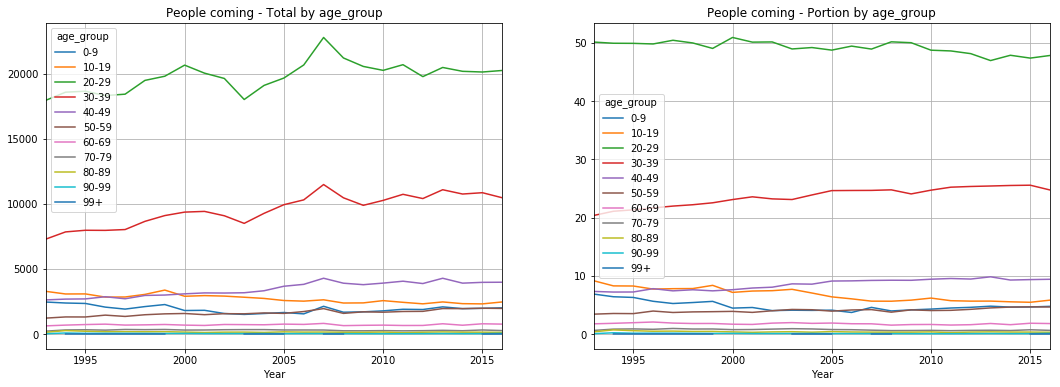

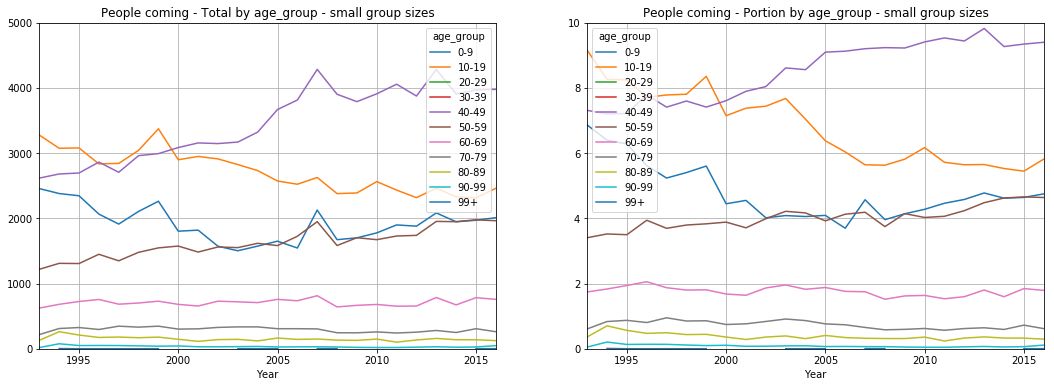

In [17]:
# In

df_in = df_subset_total(ZH_in_df, ['Year', 'age_group'], 'Total')
ZH_in_annual_by_age_group_percent = df_subset_percent(df_in, 'Year', 'age_group', 'Total')

fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1 = df_in.pivot(values='Total', index='Year',columns='age_group')
table1.plot.line(ax=axes[0], title='People coming - Total by age_group', stacked=False, grid=True )

table2 = ZH_in_annual_by_age_group_percent.pivot(values='Percent of age_group', index='Year',columns='age_group')
table2.plot.line(ax=axes[1], title='People coming - Portion by age_group', grid=True )

fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1.plot.line(ax=axes[0], title='People coming - Total by age_group - small group sizes', grid=True, ylim=(0,5000) )
table2.plot.line(ax=axes[1], title='People coming - Portion by age_group - small group sizes', grid=True , ylim=(0,10) )

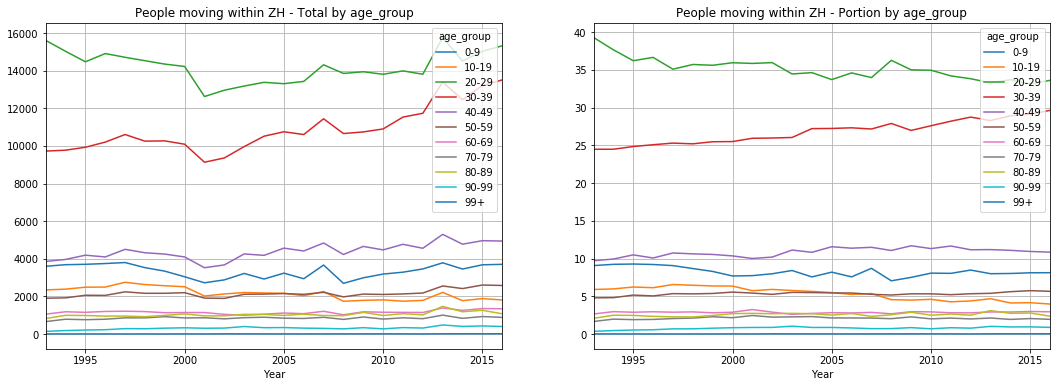

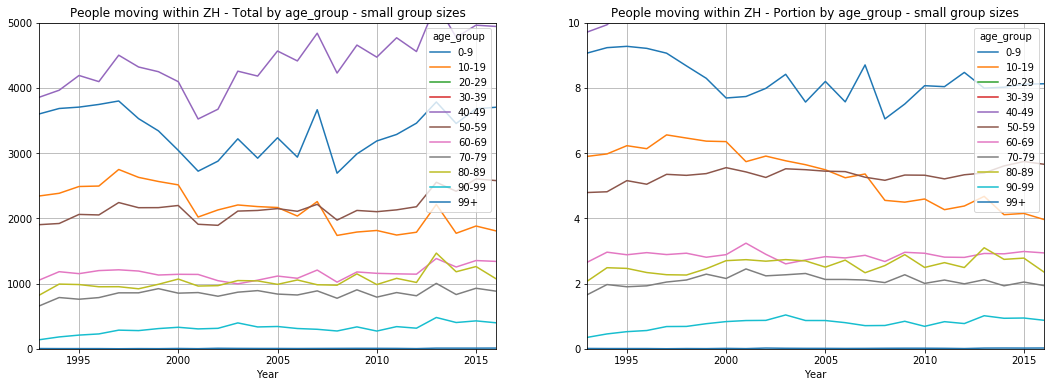

In [18]:
#Within

df_within = df_subset_total(ZH_within_df, ['Year', 'age_group'], 'Total')
ZH_within_annual_by_age_group_percent = df_subset_percent(df_within, 'Year', 'age_group', 'Total')


fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1 = df_within.pivot(values='Total', index='Year',columns='age_group')
table1.plot.line(ax=axes[0], title='People moving within ZH - Total by age_group', stacked=False, grid=True)

table2 = ZH_within_annual_by_age_group_percent.pivot(values='Percent of age_group', index='Year',columns='age_group')
table2.plot.line(ax=axes[1], title='People moving within ZH - Portion by age_group', grid=True)

fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1.plot.line(ax=axes[0], title='People moving within ZH - Total by age_group - small group sizes', grid=True, ylim=(0,5000) )
table2.plot.line(ax=axes[1], title='People moving within ZH - Portion by age_group - small group sizes', grid=True , ylim=(0,10) )

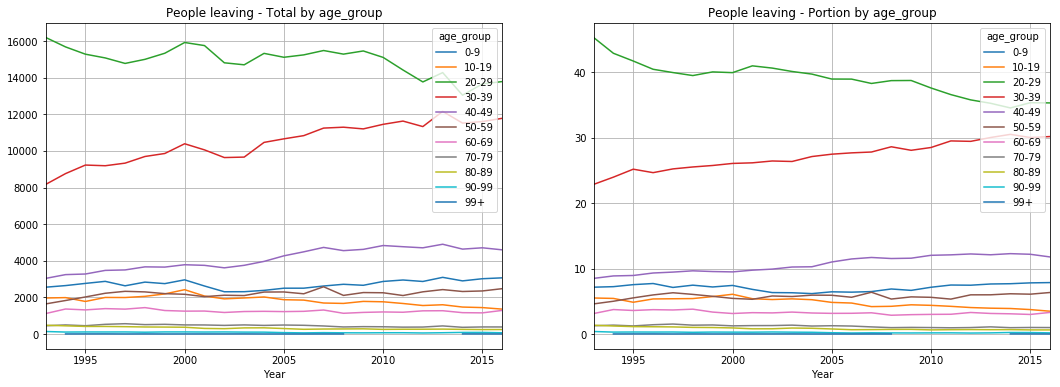

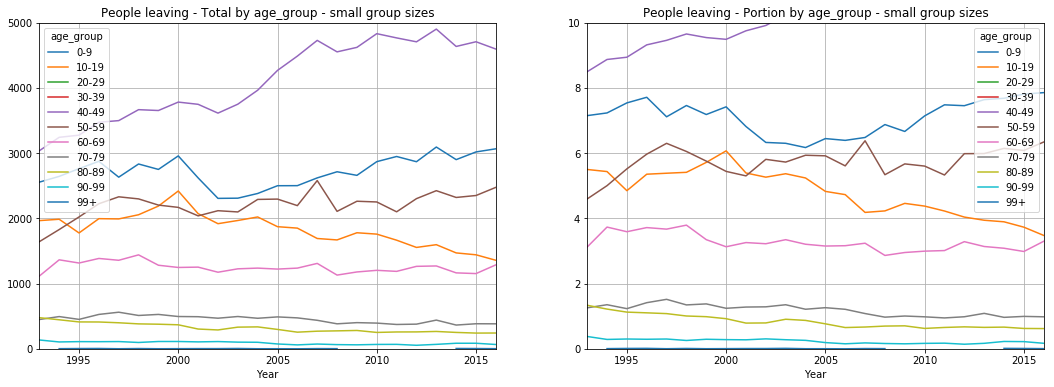

In [19]:
# Out

df_out = df_subset_total(ZH_out_df, ['Year', 'age_group'], 'Total')
ZH_out_annual_by_age_group_percent = df_subset_percent(df_out, 'Year', 'age_group', 'Total')

fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1 = df_out.pivot(values='Total', index='Year',columns='age_group')
table1.plot.line(ax=axes[0], title='People leaving - Total by age_group', stacked=False, grid=True)

table2 = ZH_out_annual_by_age_group_percent.pivot(values='Percent of age_group', index='Year',columns='age_group')
table2.plot.line(ax=axes[1], title='People leaving - Portion by age_group', grid=True)

fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1.plot.line(ax=axes[0], title='People leaving - Total by age_group - small group sizes', grid=True, ylim=(0,5000) )
table2.plot.line(ax=axes[1], title='People leaving - Portion by age_group - small group sizes', grid=True , ylim=(0,10) )

In [20]:
# Creating a data frame that focuses on young professionals '20-29' and '30-39'
young_prof = df_select_values(ZH_within_annual_by_age_group_percent, 'age_group', ['20-29','30-39'])

**Observations:** 

1) In all 3 cases the strongest groups are '20-29', then '30-39' and '40-49'. 

2) The total number of '20-29' is (up - in, steady - within, down - out).
 
The portion of '20-29' decreases over time by (-2.3% in, -5.7% within, -10% out). We could say that this age group becomes more 'sesshaft' - in relative terms.

3) There is a significant increase of the total number of '30-39' moving in general. We could conclude that people in this group decide/are  for forced to move more often. (Need comparison against overall population.)

The portion of '30-39' increases over time by (4.3% in, 5.1% within, 7.3% out). We could say that this age group becomes more 'mobile' - in relative terms.

4) Comparing children '0-9' and '10-19'. The groups are typically ranked 4 and 5.
There are more '10-19' moving to ZH, whereas '0-9' are more likely to move within ZH or leave ZH.

The total number of ‘10-19’ decreases in all 3 scenarios.

ZH_in: 1999 sees a brief spike for both age groups (not reflected in any other age group!)), and for '0-9' the spike of 2007 follows the general trend, but for ‘10-19’ it is absent. 

ZH_within: The drop of 2001 and the spikes of 2007 and 2013 are matched by both sets. 

ZH_out: 2013 on the other hand appears not noticeable for ZH_out in either group.

5) The groups 60+ , with pensioners or those close to retirement, generally do not move as much. This is particularly noticeable ZH_in where their portion is generally smaller than in the other two cases. 

’60-69’ make up around 2%,3%,4% of the three groups (in, within, out). For ZH_in  and ZH_out they set themselves apart from the older groups, whereas all the age groups 60+ for ZH_within are on comparable sales.

The profiles for the groups 60+, does not show the dips around 2001-2003, nor the spikes of 2007 or 2013. This suggest that events related to those dips and spikes did not affect pensioners. In other words those events appear to be related to the economy, affecting household incomes (but not pensions). 

#### Questions and Tasks

Quantify and make a visual comparison between portions of individual subgroups for in, within, out and total population.

1) Can we say that there was a particular change overtime?

2) For which group is the portion of against the overall population changing most significantly?

3) Plot percentage change against 1993 value for each group. Expect [20-29] steady in all 3, [30-39] up by 30% in all 3. What about the other ones? Trend appears to depend on age_group and in/within/out.

4) Are these trends similar when we focus on single/married/divorced people? (Later are a mix of the first two as they are more likely to have kids and in that case be constraint by ex-partners wanting access.)


#### Annual number of moves by marital status

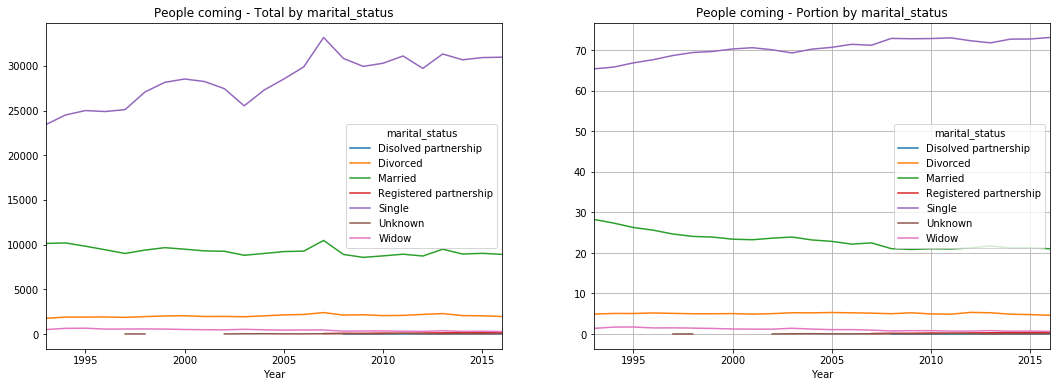

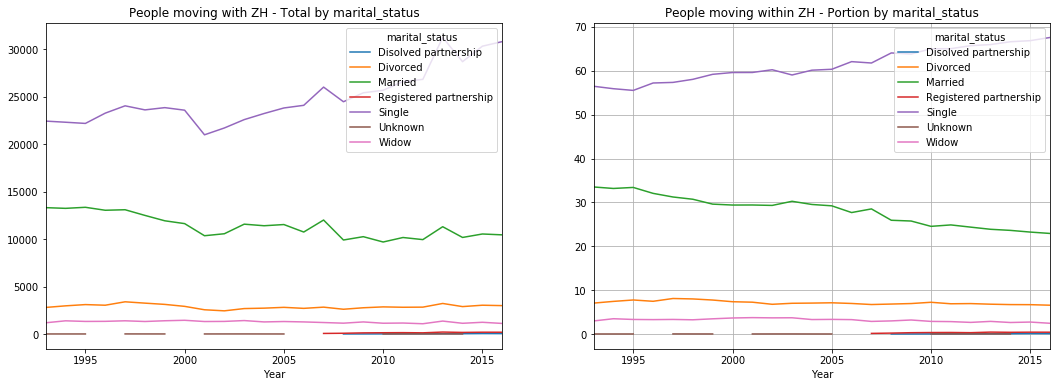

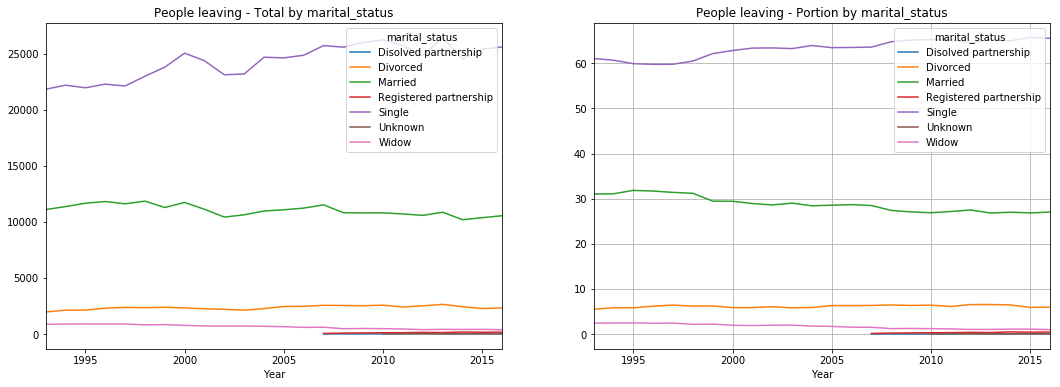

In [21]:
df_in = df_subset_total(ZH_in_df, ['Year', 'marital_status'], 'Total')
ZH_in_annual_by_marital_status_percent = df_subset_percent(df_in, 'Year', 'marital_status', 'Total')

fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1 = df_in.pivot(values='Total', index='Year',columns='marital_status')
table1.plot.line(ax=axes[0], title='People coming - Total by marital_status', stacked=False)

table2 = ZH_in_annual_by_marital_status_percent.pivot(values='Percent of marital_status', index='Year',columns='marital_status')
table2.plot.line(ax=axes[1], title='People coming - Portion by marital_status', grid=True)


df_within = df_subset_total(ZH_within_df, ['Year', 'marital_status'], 'Total')
ZH_within_annual_by_marital_status_percent = df_subset_percent(df_within, 'Year', 'marital_status', 'Total')


fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1 = df_within.pivot(values='Total', index='Year',columns='marital_status')
table1.plot.line(ax=axes[0], title='People moving with ZH - Total by marital_status', stacked=False)

table2 = ZH_within_annual_by_marital_status_percent.pivot(values='Percent of marital_status', index='Year',columns='marital_status')
table2.plot.line(ax=axes[1], title='People moving within ZH - Portion by marital_status', grid=True)


df_out = df_subset_total(ZH_out_df, ['Year', 'marital_status'], 'Total')
ZH_out_annual_by_marital_status_percent = df_subset_percent(df_out, 'Year', 'marital_status', 'Total')

fig, axes = plt.subplots(1, 2, figsize=(18,6))
table1 = df_out.pivot(values='Total', index='Year',columns='marital_status')
table1.plot.line(ax=axes[0], title='People leaving - Total by marital_status', stacked=False)

table2 = ZH_out_annual_by_marital_status_percent.pivot(values='Percent of marital_status', index='Year',columns='marital_status')
table2.plot.line(ax=axes[1], title='People leaving - Portion by marital_status', grid=True)


**Observations:** 

Note single adult people are indivdual moves, while children count as single but are dependants. So the number of moves involving indviduals is lower.

Instead, children form part of a family that moves, i.e. track the move of 2 married people (or divorced). So for married people the numbers halve to get household moves.

**Questions and tasks:** 

If we are interested in the number of households moving (independent units) then we need to drop children and halve the number of married people.

Observe that partnerships did not get counted until Year XYZ.

Look for time series how the number of Single and Married people changes over time.

### District specific analysis

We aim to carry out the following analyses:

1) Contrast the development of the percentage of foreigners in each district over time by creating the individual bar plots.

2) Consider analogous analyses using percentages of the total district population in each case for 
a) gender, b) singles, c) married people, d) age groups like [0-19], [20-39] or pensioners 

3) Plot average annual age and s.d. per district (use the population frame with the exact ages)

4) Create a population profile by district for each year and compare the ZH_within pattern for each year with this profile, as differences (positive means attractive, negative means unattractive) 

5) Calculate the flow of people between districts. Display the netflow (positive and negative) 

In [22]:
# Define the Kreis according to the districts (https://de.wikipedia.org/wiki/Stadtteile_der_Stadt_Zürich)
# Group 3 Kreise into bigger sets of 7-9 districts
Kreis1 = ['Rathaus', 'Hochschulen', 'Lindenhof', 'City']
Kreis2 = ['Wollishofen', 'Leimbach', 'Enge']
Kreis3 = ['Alt-Wiedikon', 'Friesenberg', 'Sihlfeld']
Set1= Kreis1 + Kreis2 + Kreis3 

Kreis4 = ['Werd', 'Langstrasse', 'Hard']
Kreis5 = ['Gewerbeschule', 'Escher Wyss']
Kreis6 = ['Unterstrass', 'Oberstrass']
Set2= Kreis4 + Kreis5 + Kreis6 

Kreis7 = ['Fluntern', 'Hottingen', 'Hirslanden', 'Witikon']
Kreis8 = ['Seefeld', 'Mühlebach', 'Weinegg']
Kreis9 = ['Albisrieden', 'Altstetten']
Set3= Kreis7 + Kreis8 + Kreis9 

Kreis10 = ['Höngg', 'Wipkingen']
Kreis11 = ['Affoltern', 'Oerlikon', 'Seebach']
Kreis12 = ['Saatlen', 'Schwamendingen-Mitte', 'Hirzenbach']
Set4= Kreis10 + Kreis11 + Kreis12 


#### Total population by districts

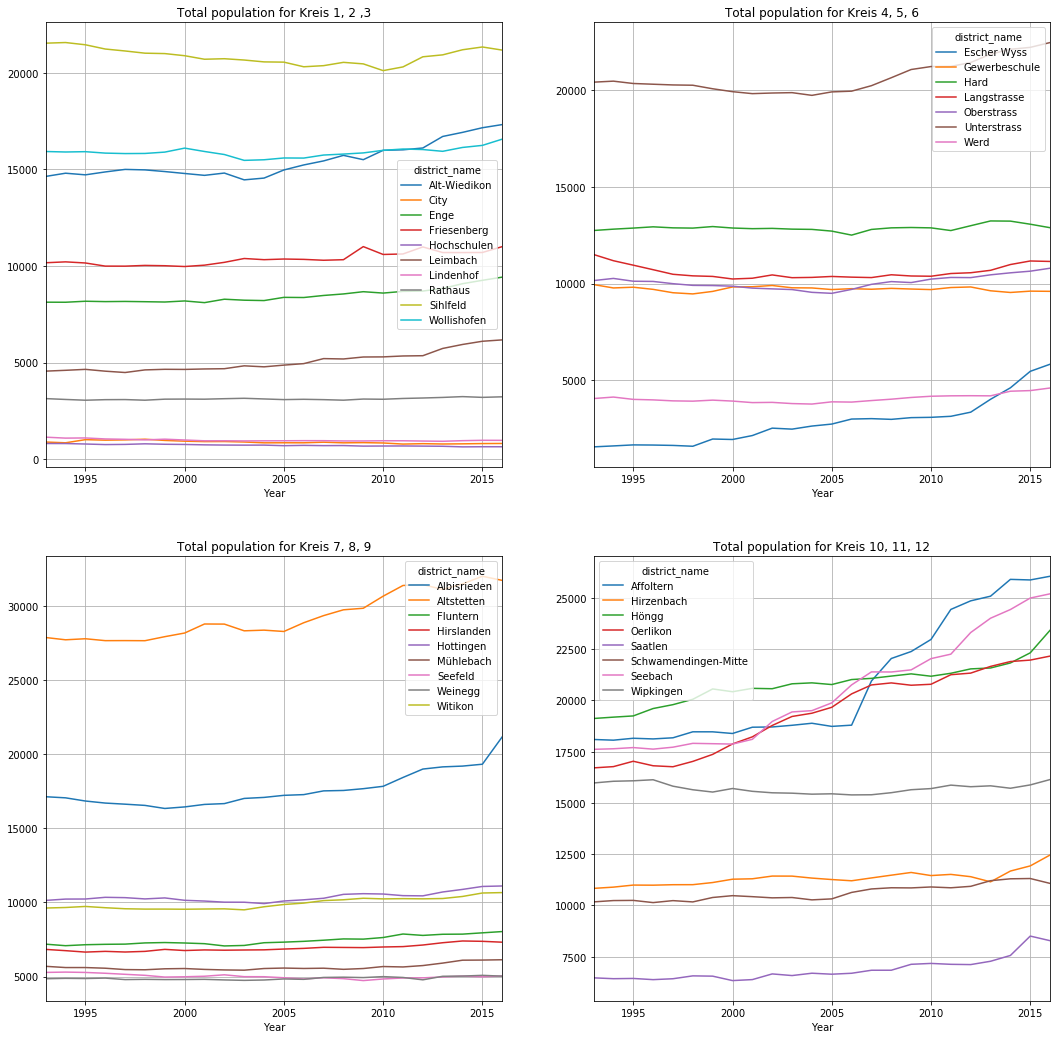

In [23]:
ZH_popul_Total_Set1 = df_select_values(ZH_popul_Total, 'district_name', Set1)
ZH_popul_Total_Set2 = df_select_values(ZH_popul_Total, 'district_name', Set2)
ZH_popul_Total_Set3 = df_select_values(ZH_popul_Total, 'district_name', Set3)
ZH_popul_Total_Set4 = df_select_values(ZH_popul_Total, 'district_name', Set4)

#Plot the 4 sets
fig, axes = plt.subplots(2, 2, figsize=(18,18))

ZH_popul_Total_Set1.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,0], title='Total population for Kreis 1, 2 ,3', stacked=False, grid=True)

ZH_popul_Total_Set2.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,1],title='Total population for Kreis 4, 5, 6', stacked=False, grid=True)

ZH_popul_Total_Set3.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,0], title='Total population for Kreis 7, 8, 9', stacked=False, grid=True)

ZH_popul_Total_Set4.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,1], title='Total population for Kreis 10, 11, 12', stacked=False, grid=True)



** Observation ** 

Overall we can spot different trends (with examples):

a) some stagnated: Rathaus, City, Hochschulen

b) some grew steadily at similar rates: Altstetten, Oerlikon (with different rates for 1997-2007 and 2007-2017), Hoengg

c) others were stagnating and then started to increase at a specific point in time: Affoltern from 2007, Seebach from 2000, Escher Wyss from 1998 and then even more from 2012.

d) and some decline slightly before recovering: Langstrasse, Wipkingen

Of course there may be various reasons for these trends. Down town has limited capacity of living space and little chnce to expand. Outer districts may gradually build up open (green) space or convert industrial areas (brown space) into residential areas. Affoltern seems to be an example where there was a sudden increase in people moving there. Given the prior stagnation this suggest a sudden availability of living space through new buildings.

However we can observe that Hard, Langstrasse, Werd and Gewerbeschule all stagnate and all lie in Kreis 4 und 5.

Similarly Saatlen, Schwamendingen-Mitte, Hirzenbach stagnate and all lie in Kries 12.

In the final two panels Altstetten, (Albisrieden,) Affoltern, Hoengg, Oerlikon and Seebach all show growths. These districts all lie along teh North-West periphery in Kreis 9, 10, 11.

The centre and the South (Kreis 2, 3, 8) are mostly static.

So there are some clear indicators of geolocation relting to growht here. (and this was to be expected)

** Questions **

How did the age and gender distribution change (or not) with time in districts following different trends?

Did the distribution of people moving to Affoltern in the years after 2007 show a characteristic profile?

#### The evolution of the percentage of foreigners per district over time

We calculate the percentage of amongst the population a) in ZH, b) in each district. This allows us to measure how international individual districts are.

We want to analyse these rates over time to see whether districts became more diverse or less. 

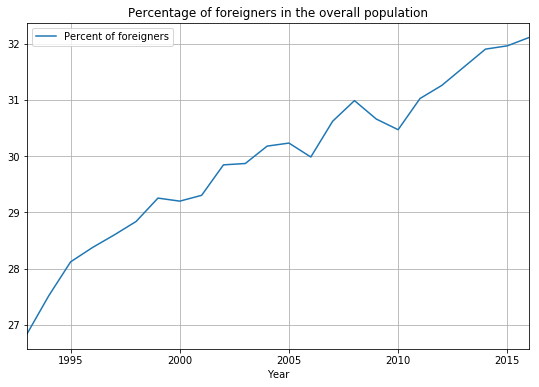

In [24]:
# Calculate the annual total number of foreigners in ZH and their portion of the ZH population

ZH_CHnonCH_percent = df_subset_percent(ZH_popul, ['Year'], 'CH_nonCH', 'Total')
ZH_Foreign_percent =ZH_CHnonCH_percent[ZH_CHnonCH_percent['CH_nonCH']=="Foreign"]


ZH_Foreign_percent.rename(columns={'Percent of CH_nonCH': 'Percent of foreigners'}, inplace=True)

ZH_Foreign_percent.plot.line(x='Year', y='Percent of foreigners', grid=True, figsize=(9,6), title='Percentage of foreigners in the overall population')

We can see that the overall population has clearer become more international. The rate of foreigners has steadily increased from27% to 32%, there is now 1 foreigner for every 2 swiss people.

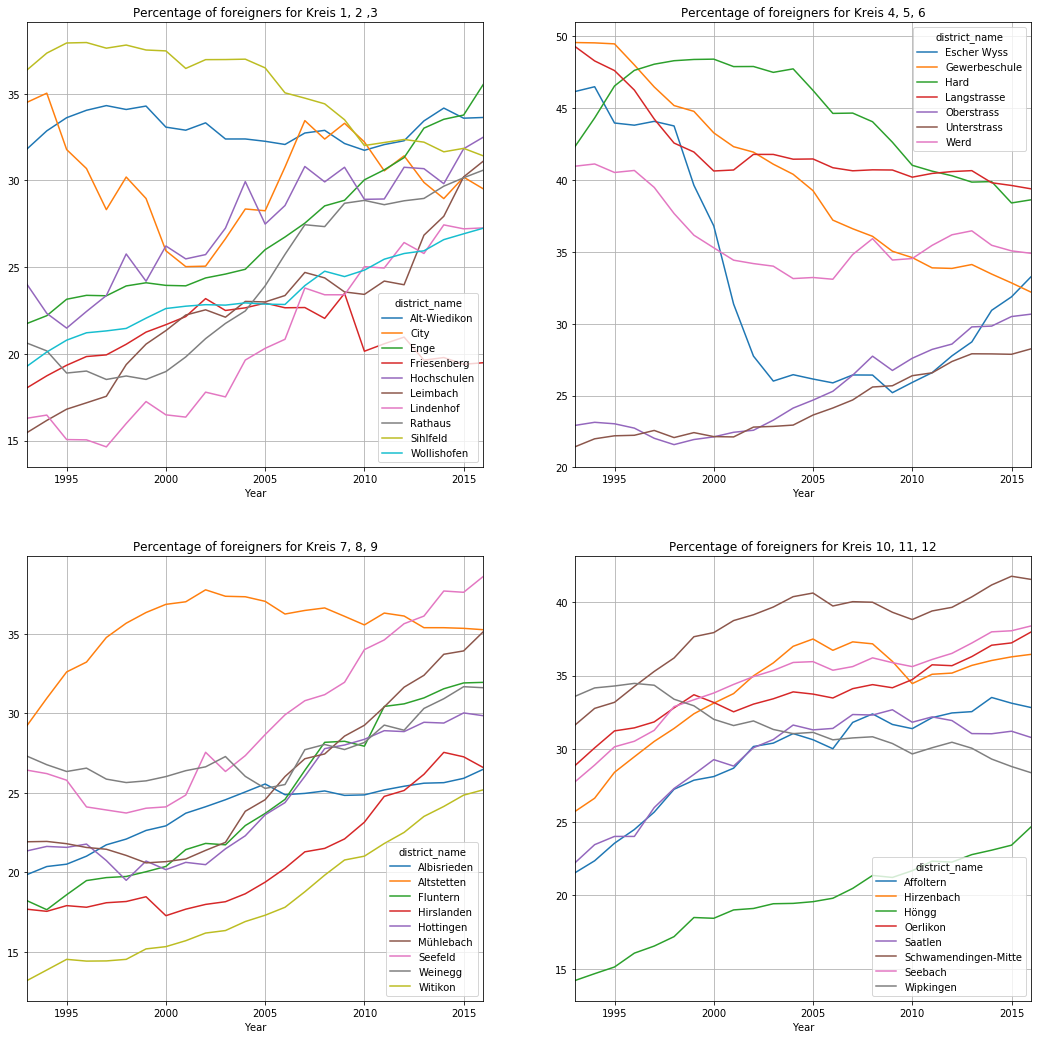

In [25]:
# Calculate the annual number of foreigners per dictrict and their portion of the district population
# Use df_subset_percent(df, retain_groups, percent_group, total_column)
ZH_district_CHnonCH_percent = df_subset_percent(ZH_popul, ['Year', 'district_name'], 'CH_nonCH', 'Total')
# Select foreigners (Foreign)
ZH_district_Foreign_percent =ZH_district_CHnonCH_percent[ZH_district_CHnonCH_percent['CH_nonCH']=="Foreign"]


# Plotting percentage of foreigners per district over time
ZH_district_Foreign_percent_Set1 = df_select_values(ZH_district_Foreign_percent, 'district_name', Set1)
ZH_district_Foreign_percent_Set2 = df_select_values(ZH_district_Foreign_percent, 'district_name', Set2)
ZH_district_Foreign_percent_Set3 = df_select_values(ZH_district_Foreign_percent, 'district_name', Set3)
ZH_district_Foreign_percent_Set4 = df_select_values(ZH_district_Foreign_percent, 'district_name', Set4)

#Plot the 4 sets
fig, axes = plt.subplots(2, 2, figsize=(18,18))

ZH_district_Foreign_percent_Set1.pivot(values='Percent of CH_nonCH', index='Year',columns='district_name').plot.line(
    ax=axes[0,0], title='Percentage of foreigners for Kreis 1, 2 ,3', stacked=False, grid=True)

ZH_district_Foreign_percent_Set2.pivot(values='Percent of CH_nonCH', index='Year',columns='district_name').plot.line(
    ax=axes[0,1],title='Percentage of foreigners for Kreis 4, 5, 6', stacked=False, grid=True)

ZH_district_Foreign_percent_Set3.pivot(values='Percent of CH_nonCH', index='Year',columns='district_name').plot.line(
    ax=axes[1,0], title='Percentage of foreigners for Kreis 7, 8, 9', stacked=False, grid=True)

ZH_district_Foreign_percent_Set4.pivot(values='Percent of CH_nonCH', index='Year',columns='district_name').plot.line(
    ax=axes[1,1], title='Percentage of foreigners for Kreis 10, 11, 12', stacked=False, grid=True)

**Observations**

We see a very clear trend of rising rates of foreigners in all of Kreis 7-12 (with the exception of Wipkingen).
Rates in 1993 were between 13% and 34% and have risen to 25% to 42%. However in Kreis 10-12 rates have mostly plateaued since 2005, whereas Kreis 7-9 continuously increased.

Kreis 1 and 2 have similarly increases (City has fluctuated), as has Kreis 6 (Oberstrass und Unterstrass).

In contrast in Kreis 3 (Friesenberg, Sihlfield, Alt-Wiedikon) 4 and 5 rates have stagnated or declined. Friesenberg has by far the lowest rate of foreigners in 2016 (< 20% - all others at least 25%). 

Escher Wyss is an exceptional case with the rate of foreigners collapsing from 44% to 26% in just 5 years (1998-2003). However, rates have recovered steadily since 2010 to 33%.

** Question**

It is surprising to see such clear distinctions according to Kreis boundaries, rather than districts within a Kreis acting distinctly. Do the Kreis collectively have the same politcal and adminstrative decision making bodies that homogenise planning and socio-economic decisions?

#### The evolution of the gender gap per district over time

We analysed the gender gaps earlier. The overall population had showed a decline from 52.5% to 50% over time. However the moves did not reflect that.

Now we look at individual districts.

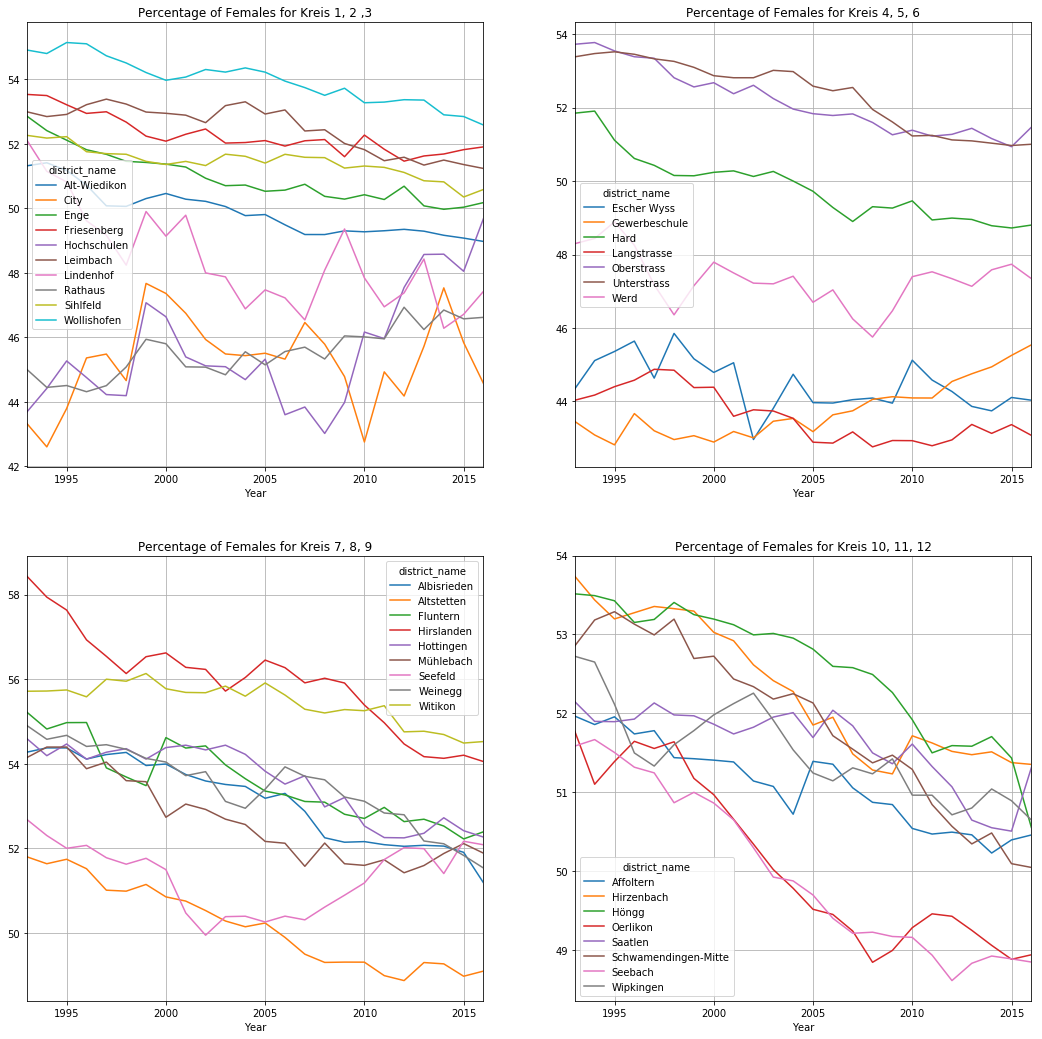

In [26]:
#df_subset_percent(df, retain_groups, percent_group, total_column)
ZH_district_gender_percent = df_subset_percent(ZH_popul, ['Year', 'district_name'], 'gender', 'Total')
# Select females
ZH_district_Female_percent =ZH_district_gender_percent[ZH_district_gender_percent['gender']=="F"]


# Plotting percentage of Femaleers per district over time
ZH_district_Female_percent_Set1 = df_select_values(ZH_district_Female_percent, 'district_name', Set1)
ZH_district_Female_percent_Set2 = df_select_values(ZH_district_Female_percent, 'district_name', Set2)
ZH_district_Female_percent_Set3 = df_select_values(ZH_district_Female_percent, 'district_name', Set3)
ZH_district_Female_percent_Set4 = df_select_values(ZH_district_Female_percent, 'district_name', Set4)

#Plot the 4 sets
fig, axes = plt.subplots(2, 2, figsize=(18,18))

ZH_district_Female_percent_Set1.pivot(values='Percent of gender', index='Year',columns='district_name').plot.line(
    ax=axes[0,0], title='Percentage of Females for Kreis 1, 2 ,3', stacked=False, grid=True)

ZH_district_Female_percent_Set2.pivot(values='Percent of gender', index='Year',columns='district_name').plot.line(
    ax=axes[0,1],title='Percentage of Females for Kreis 4, 5, 6', stacked=False, grid=True)

ZH_district_Female_percent_Set3.pivot(values='Percent of gender', index='Year',columns='district_name').plot.line(
    ax=axes[1,0], title='Percentage of Females for Kreis 7, 8, 9', stacked=False, grid=True)

ZH_district_Female_percent_Set4.pivot(values='Percent of gender', index='Year',columns='district_name').plot.line(
    ax=axes[1,1], title='Percentage of Females for Kreis 10, 11, 12', stacked=False, grid=True)

**Observations**

In 1993 the rate of women was above 50% in most districts (51%-58%); and all of these districts the rate has slowly but steadily fallen to 49%-55%. The exceptions are the districts in Kreis 1, 4 and 5, where rates have always been below 50%, oscillating between 42% and 50% (Hard declines from 52% to 49%).

This is in contrast to the observations we made about the consistent gender gap among people arriving in ZH and moving within ZH which could in parts explain the gradual decline above. However even the people leaving ZH were predominantly women. 

** Question**

Since married couples split their part of the population in a 50-50 ratio, the above figures suggest that the ratios of female amongst singles should follow the above trends even more. Since women typically live longer than men and hence outlive them in most marriages, we hence suspect that the portion of female widows is higher than 50%.

#### The evolution of the age groups per district over time

**Description:**

We are interested in the age decomposition of ZH. We split the population into 5 groups and analyse 4 of them in more detail. The 4 groups have been chosen as they are on similar scales. They are: 

a) children [0-19], 

b) young professionals [20-29]

c) mid professionals [30-39]

d) seniors [60+]

(We are obmitting the older professionals [40-59] here.)

First we calculate and plot the portions of each group in the overall population of ZH. Then we repeat the analyis at district level.

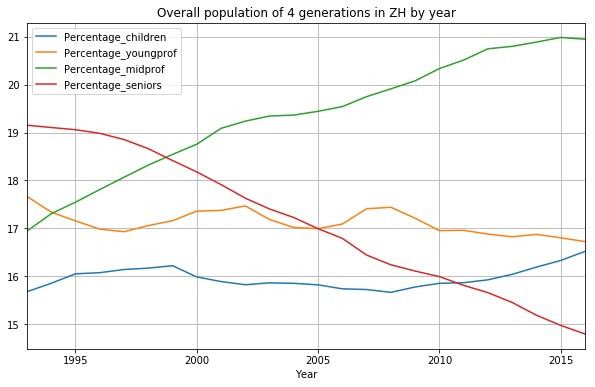

In [27]:
#df_subset_percent(df, retain_groups, percent_group, total_column)
# Annual numbers
ZH_age_percent = df_subset_percent(ZH_popul, ['Year'], 'age_group5', 'Total')
# Annual numbers by district
ZH_district_age_percent = df_subset_percent(ZH_popul, ['Year', 'district_name'], 'age_group5', 'Total')


# Finding the annual percentages for children, young professionals and seniors in the overall population

#df_select_values(df, selected_column, value_list):
ZH_children_percent =df_select_values(ZH_age_percent, "age_group5", ["0-4", "5-9","10-14","15-19"])
ZH_children_percent =df_subset_total(ZH_children_percent, "Year", "Percent of age_group5").set_index('Year')
ZH_children_percent.rename(columns={'Total': 'Percentage_children'}, inplace=True)

# Originally had:
# ZH_youngprof_percent =df_select_values(ZH_age_percent, "age_group5", ["20-24", "25-29", "30-34", "35-39"])
# Then decided to split into yprof "20-29" and midprof "30-39"
ZH_youngprof_percent =df_select_values(ZH_age_percent, "age_group5", ["20-24", "25-29"])
ZH_youngprof_percent =df_subset_total(ZH_youngprof_percent, "Year", "Percent of age_group5").set_index('Year')
ZH_youngprof_percent.rename(columns={'Total': 'Percentage_youngprof'}, inplace=True)


ZH_midprof_percent =df_select_values(ZH_age_percent, "age_group5", ["30-34", "35-39"])
ZH_midprof_percent =df_subset_total(ZH_midprof_percent, "Year", "Percent of age_group5").set_index('Year')
ZH_midprof_percent.rename(columns={'Total': 'Percentage_midprof'}, inplace=True)


ZH_seniors_percent =df_select_values(ZH_age_percent, "age_group5", 
                                                ["65-69","70-74","75-79","80-84","85-89","90-94","95-99","99+"])
ZH_seniors_percent =df_subset_total(ZH_seniors_percent, "Year", "Percent of age_group5").set_index('Year')
ZH_seniors_percent.rename(columns={'Total': 'Percentage_seniors'}, inplace=True)

# Join the three dataframes and plot them in one graph
ZH_generations = pd.concat([ZH_children_percent, ZH_youngprof_percent, ZH_midprof_percent, ZH_seniors_percent], axis=1 )
ZH_generations.plot.line(title='Overall population of 4 generations in ZH by year', grid=True,figsize=(10,6) )

In [28]:
# Finding the annual percentages for children, young professionals and seniors in the overall population

#df_select_values(df, selected_column, value_list):
ZH_district_children_percent =df_select_values(ZH_district_age_percent, "age_group5", ["0-4", "5-9","10-14","15-19"])
ZH_district_children_percent =df_subset_total(ZH_district_children_percent, ["Year", "district_name"], "Percent of age_group5")

# Orignally [20-39] then split
# ZH_district_youngprof_percent =df_select_values(ZH_district_age_percent, "age_group5", ["20-24", "25-29","30-34","35-39"])

ZH_district_youngprof_percent =df_select_values(ZH_district_age_percent, "age_group5", ["20-24", "25-29"])
ZH_district_youngprof_percent =df_subset_total(ZH_district_youngprof_percent, ["Year", "district_name"], "Percent of age_group5")

#ZH_district_midprof_percent =df_select_values(ZH_district_age_percent, "age_group5", ["30-34","35-39"])
ZH_district_midprof_percent =df_select_values(ZH_district_age_percent, "age_group5", ["30-34","35-39"])
ZH_district_midprof_percent =df_subset_total(ZH_district_midprof_percent, ["Year", "district_name"], "Percent of age_group5")

ZH_district_seniors_percent =df_select_values(ZH_district_age_percent, "age_group5", 
                                                ["65-69","70-74","75-79","80-84","85-89","90-94","95-99","99+"])
ZH_district_seniors_percent =df_subset_total(ZH_district_seniors_percent, ["Year", "district_name"], "Percent of age_group5")


#### The evolution of the percentage of children per district over time

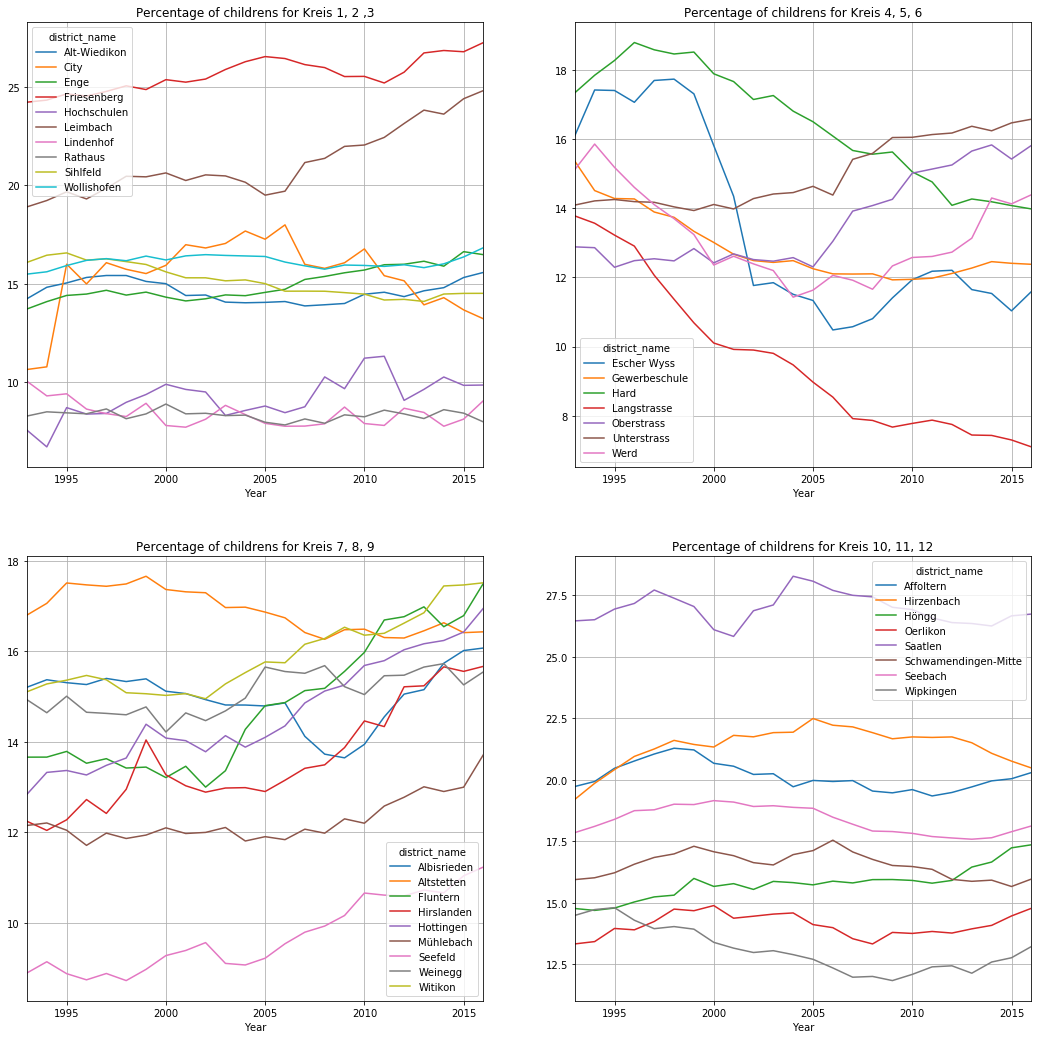

In [29]:
# Plotting percentage of children per district over time
ZH_district_children_percent_Set1 = df_select_values(ZH_district_children_percent, 'district_name', Set1)
ZH_district_children_percent_Set2 = df_select_values(ZH_district_children_percent, 'district_name', Set2)
ZH_district_children_percent_Set3 = df_select_values(ZH_district_children_percent, 'district_name', Set3)
ZH_district_children_percent_Set4 = df_select_values(ZH_district_children_percent, 'district_name', Set4)

#Plot the 4 sets
fig, axes = plt.subplots(2, 2, figsize=(18,18))

ZH_district_children_percent_Set1.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,0], title='Percentage of childrens for Kreis 1, 2 ,3', stacked=False, grid=True)

ZH_district_children_percent_Set2.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,1],title='Percentage of childrens for Kreis 4, 5, 6', stacked=False, grid=True)

ZH_district_children_percent_Set3.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,0], title='Percentage of childrens for Kreis 7, 8, 9', stacked=False, grid=True)

ZH_district_children_percent_Set4.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,1], title='Percentage of childrens for Kreis 10, 11, 12', stacked=False, grid=True)

#### The evolution of the percentage of young professionals per district over time

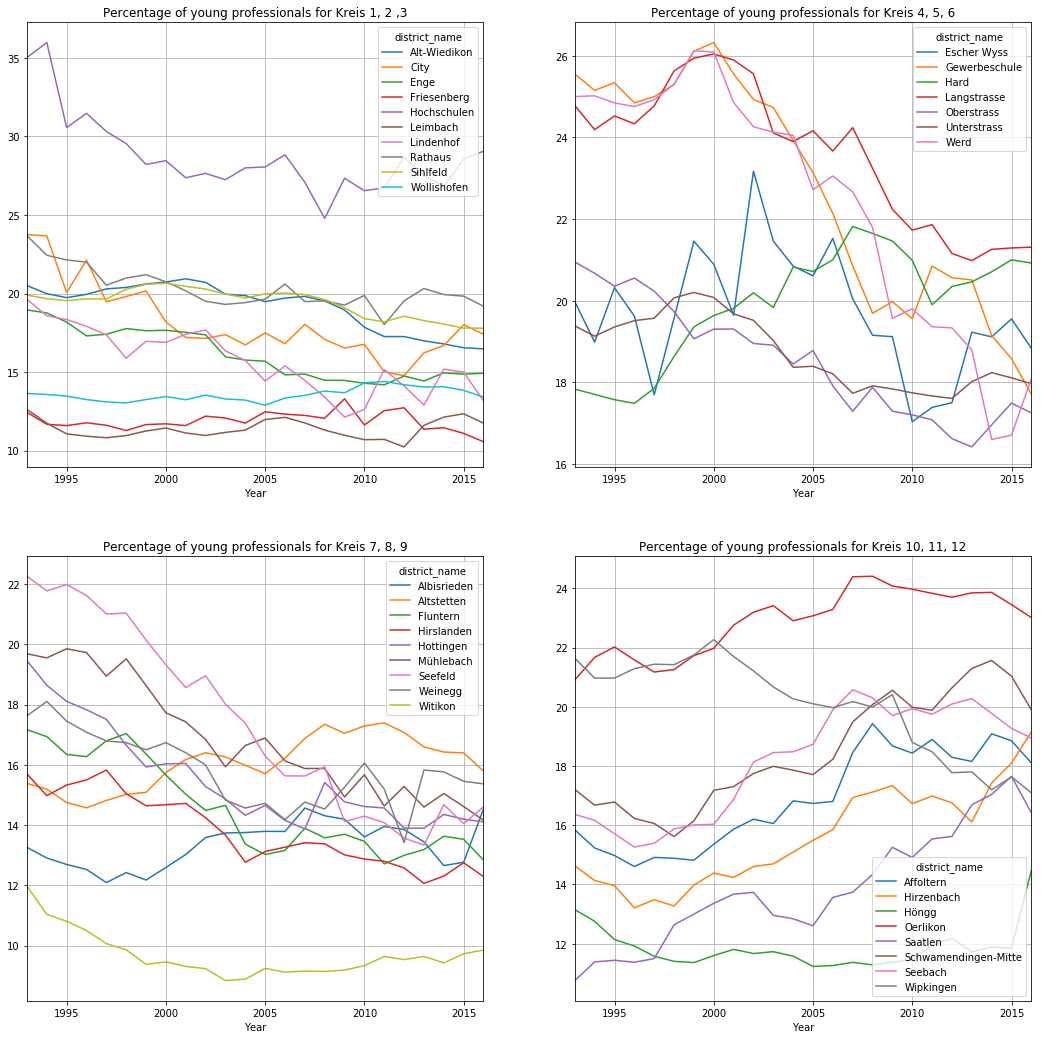

In [30]:
# Plotting percentage of young professionals per district over time
ZH_district_youngprof_percent_Set1 = df_select_values(ZH_district_youngprof_percent, 'district_name', Set1)
ZH_district_youngprof_percent_Set2 = df_select_values(ZH_district_youngprof_percent, 'district_name', Set2)
ZH_district_youngprof_percent_Set3 = df_select_values(ZH_district_youngprof_percent, 'district_name', Set3)
ZH_district_youngprof_percent_Set4 = df_select_values(ZH_district_youngprof_percent, 'district_name', Set4)

#Plot the 4 sets
fig, axes = plt.subplots(2, 2, figsize=(18,18))

ZH_district_youngprof_percent_Set1.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,0], title='Percentage of young professionals for Kreis 1, 2 ,3', stacked=False, grid=True)

ZH_district_youngprof_percent_Set2.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,1],title='Percentage of young professionals for Kreis 4, 5, 6', stacked=False, grid=True)

ZH_district_youngprof_percent_Set3.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,0], title='Percentage of young professionals for Kreis 7, 8, 9', stacked=False, grid=True)

ZH_district_youngprof_percent_Set4.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,1], title='Percentage of young professionals for Kreis 10, 11, 12', stacked=False, grid=True)

#### The evolution of the percentage of mid professionals per district over time

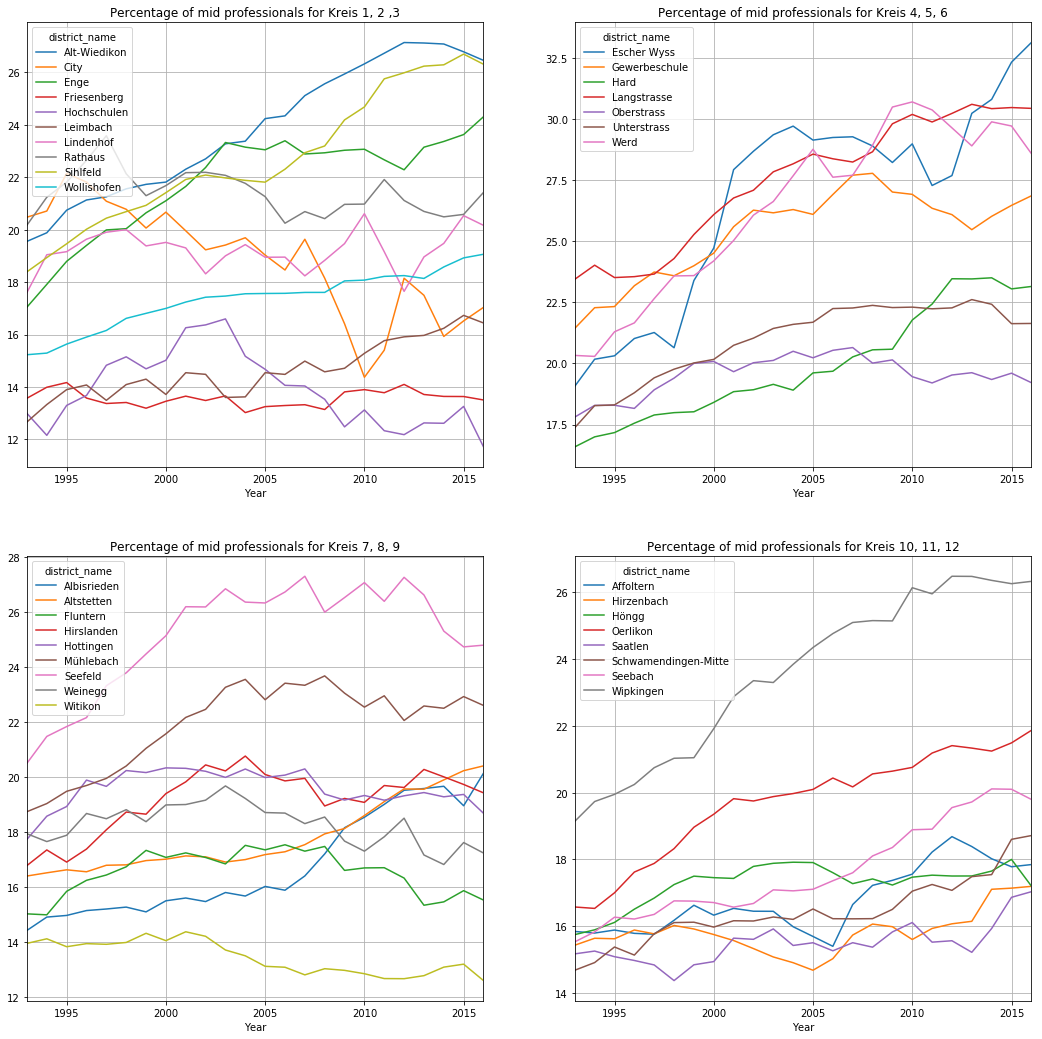

In [31]:
# Plotting percentage of mid professionals per district over time
ZH_district_midprof_percent_Set1 = df_select_values(ZH_district_midprof_percent, 'district_name', Set1)
ZH_district_midprof_percent_Set2 = df_select_values(ZH_district_midprof_percent, 'district_name', Set2)
ZH_district_midprof_percent_Set3 = df_select_values(ZH_district_midprof_percent, 'district_name', Set3)
ZH_district_midprof_percent_Set4 = df_select_values(ZH_district_midprof_percent, 'district_name', Set4)

#Plot the 4 sets
fig, axes = plt.subplots(2, 2, figsize=(18,18))

ZH_district_midprof_percent_Set1.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,0], title='Percentage of mid professionals for Kreis 1, 2 ,3', stacked=False, grid=True)

ZH_district_midprof_percent_Set2.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,1],title='Percentage of mid professionals for Kreis 4, 5, 6', stacked=False, grid=True)

ZH_district_midprof_percent_Set3.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,0], title='Percentage of mid professionals for Kreis 7, 8, 9', stacked=False, grid=True)

ZH_district_midprof_percent_Set4.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,1], title='Percentage of mid professionals for Kreis 10, 11, 12', stacked=False, grid=True)

#### The evolution of the percentage of seniors per district over time

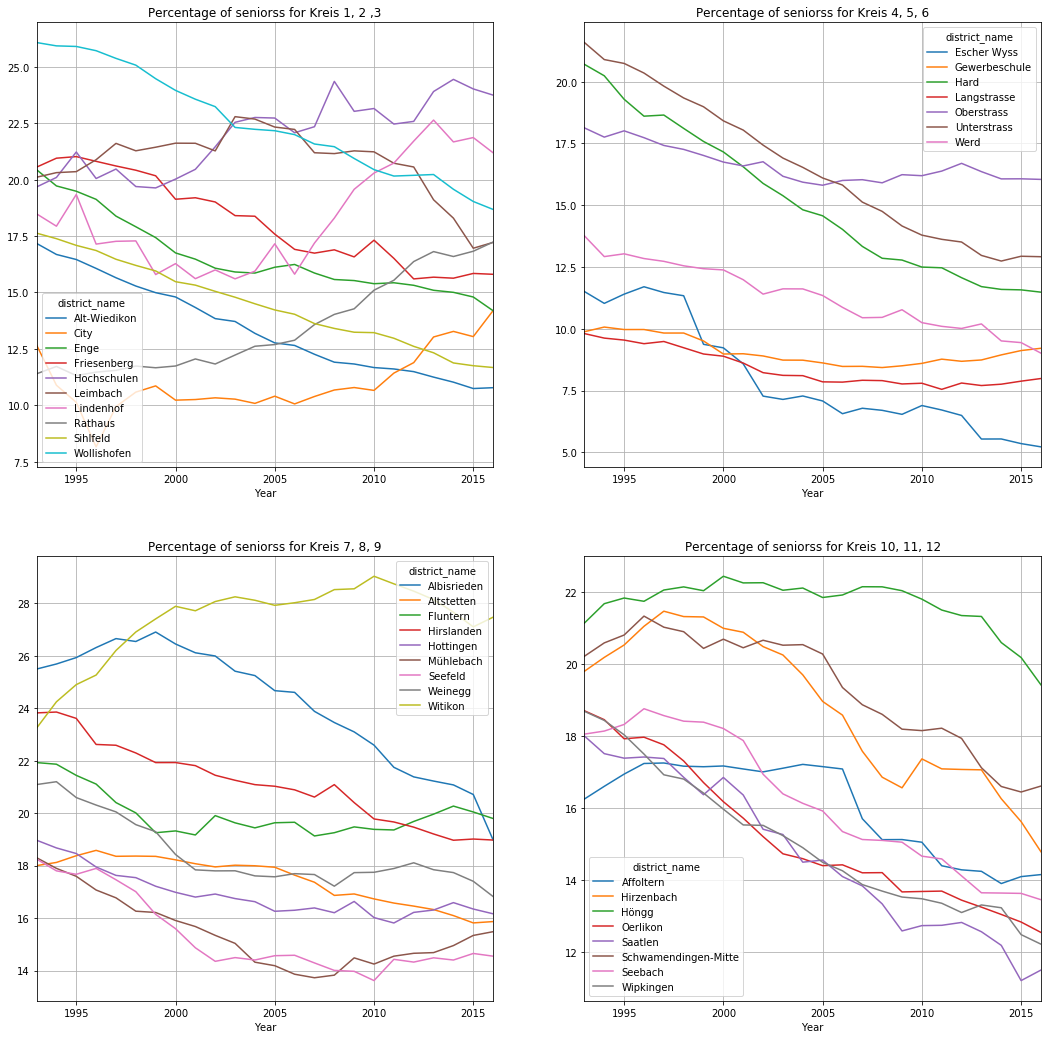

In [32]:
# Plotting percentage of seniors per district over time
ZH_district_seniors_percent_Set1 = df_select_values(ZH_district_seniors_percent, 'district_name', Set1)
ZH_district_seniors_percent_Set2 = df_select_values(ZH_district_seniors_percent, 'district_name', Set2)
ZH_district_seniors_percent_Set3 = df_select_values(ZH_district_seniors_percent, 'district_name', Set3)
ZH_district_seniors_percent_Set4 = df_select_values(ZH_district_seniors_percent, 'district_name', Set4)

#Plot the 4 sets
fig, axes = plt.subplots(2, 2, figsize=(18,18))

ZH_district_seniors_percent_Set1.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,0], title='Percentage of seniorss for Kreis 1, 2 ,3', stacked=False, grid=True)

ZH_district_seniors_percent_Set2.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[0,1],title='Percentage of seniorss for Kreis 4, 5, 6', stacked=False, grid=True)

ZH_district_seniors_percent_Set3.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,0], title='Percentage of seniorss for Kreis 7, 8, 9', stacked=False, grid=True)

ZH_district_seniors_percent_Set4.pivot(values='Total', index='Year',columns='district_name').plot.line(
    ax=axes[1,1], title='Percentage of seniorss for Kreis 10, 11, 12', stacked=False, grid=True)

**Observations**

 We see that the percentages of children and young professionals in the overall population are stable over the years. The age group 30-39 increases from 17% to 21% which means their actual numbers will have risen by over 20%. In contrast the portion of over 60 and over has declined. As the city grows their portion steadily dropped from 19% to 15%.
 
 Overall the city has gotten 'younger in the middle ages', as the shift is driven by the number of people in their '30-39' and not as usually expected by the lower age groups.

For children, there is no general trend apart from some isolated districts that had increases. Escher Wyss had a sharp decline in the early 2000, which suggest that the district became unattractive for families with children who left the district. For Langstrasse teh decline was more even over the full 23 years.

Young professionals (20-29) have significantly turned away from most of Kreis 4,5 and 6. Similar observations hold for some districts in Kreis 7-9. Instead  they have moved to districts 10-12.



# Milestone 3

## Maps and widgets

In this section we plot maps over different moving ratios. In addition to the maps we also implemented widgets which allows the user to change certain parameters, like the year.

In order to use the widgets the notebook most be opened in Jupyter.

## Size of districts
Each district is categorised into one of three different sizes. Large if the population is larger then 20 000, medium if the population size is between 10 000 and 20 000 and small if the population is smaller then 10 000.

In [33]:
ZH_popul_2016 = ZH_popul[ZH_popul['Year']==2016]
#ZH_popul_2016_dist = ZH_popul_2016[]
district_size = df_subset_percent(ZH_popul_2016, 'Year', 'district_name','Total') 
size = []
for district1 in district_size.district_name :
    dataframe = district_size[district_size['district_name']==district1]
    if dataframe.Total.iloc[0] > 20000 :
        size.append('Large')
    elif dataframe.Total.iloc[0]>10000 :
        size.append('Medium')
    else :
        size.append('Small')
# Append the size to the dataframe
district_size['Size'] = size
district_size.Size.value_counts()

Small     15
Medium    11
Large     8 
Name: Size, dtype: int64

## Map over size of district
There are 15 small district, 11 medium size district and 8 large district. 
Blue color inidicats a large district, green for a medium district and red for a small district.



In [34]:
# Define a function for the color of different district size. Blue/purple color indicats a large district, 
# green for a medium size district and red for a small district.
def district_size_color(district):
    dist_size = district_size.loc[district_size['district_name'] == district, 'Size'].values[0]
    if dist_size == 'Large':
        return '#0000ff'
    elif dist_size == 'Medium':
        return '#00ff33'
    else :
        return '#ff0000'

In [35]:
#Plot the map
zurich_geo_path = r'Data/ZH_district_geo.json'
geo_json_data = json.load(open(zurich_geo_path))
zh_map = folium.Map(location=[47.3769, 8.5417], zoom_start=12,tiles='cartodbpositron')
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': district_size_color(feature['properties']['qname']),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(zh_map)

zh_map

## Observations
The northen districts of Zurich are the larges one, the most central districts are the smalest and the west/east district are the middle size districts.

## Where do the foreigners move?

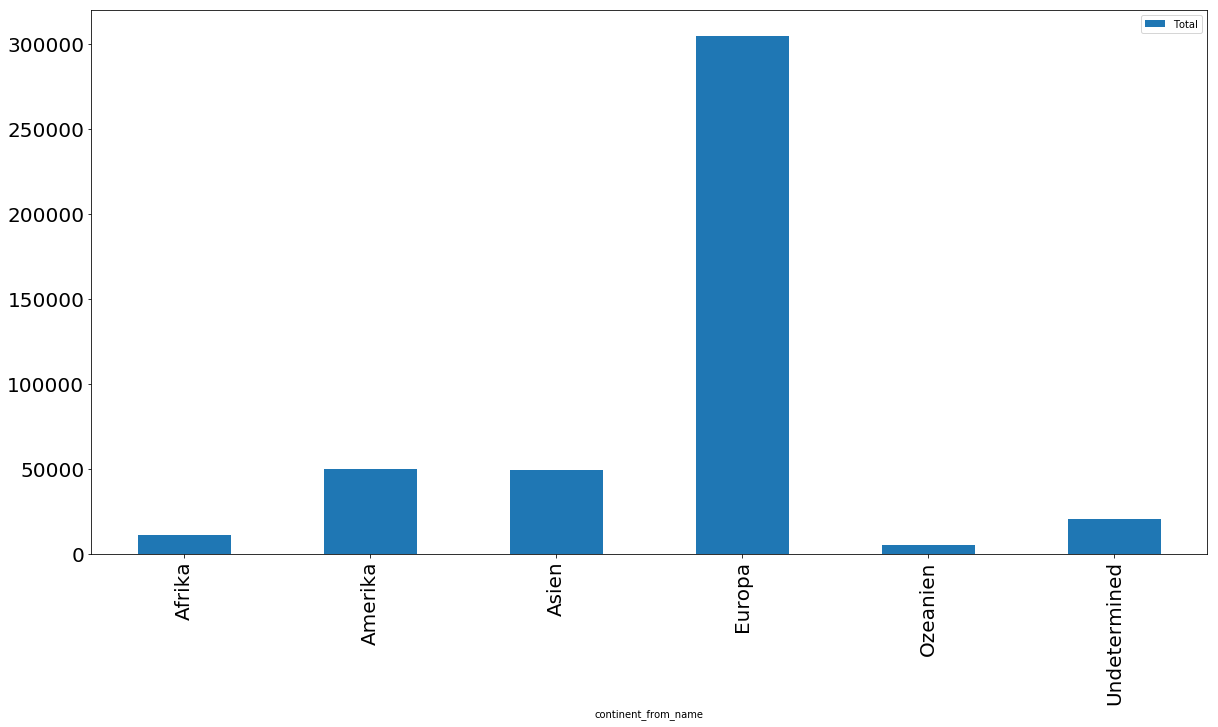

In [36]:
# Bar plot over where forigeners come from

#We do not include Swiss citizen
subcontinent = ZH_in_df[ZH_in_df.country_from_name != 'Schweiz']
subcontinent = df_subset_total(subcontinent, ['continent_from_name'], 'Total')
subcontinent.plot.bar(x='continent_from_name',figsize=(20,10),fontsize=20)

In the bar plot above we notice that most of the incoming people are from Europe and in particular Central Europe. Therefore have we for now devided these into 3 groups: Swiss, European and Non-European.

In [37]:
# This is a function that given the year, y, and the nationality (Swiss, European or Non-European), returns a dataframe
# with ratio of people moving into the diffrent district compared to how many already lives there for the respective
# year and nationality.

def year(y,nationality):
    # Creats a dataframe of ZH_in_df where only the rows with Year y is kept
    ZH_in_df_year = ZH_in_df[ZH_in_df.Year == y]
    #Rest index of this dataframe
    ZH_popul_year = ZH_popul[ZH_popul.Year == y].reset_index()
    
    ZH_popul_year_total = df_subset_total(ZH_popul_year, ['Year','district_name'], 'Total')
    # Creat a dataframe of the above but this time we only keep the Swiss citizen
    ZH_in_df_swiss = ZH_in_df_year[ZH_in_df_year.country_from_name == 'Schweiz']
    # Creat a datafram with on non swiss citizen
    ZH_in_df_non_swiss = ZH_in_df_year[ZH_in_df_year.country_from_name != 'Schweiz']
    # New dataframe where we save the results of the ratios later, and we only keep the disticts name.
    ZH_in_precentage1 = df_subset_total(ZH_in_df_non_swiss, ['Year','district_to_name'], 'Total')
    
    ZH_in_precentage = ZH_in_precentage1[['district_to_name']]
    # If nationality is Swiss calculate the above explained ratio
    if nationality == 'Swiss':
        
        ZH_popul_CH_year =  ZH_popul_CH[ZH_popul_CH.Year == y]

        ZH_popul_CH_year_swiss = ZH_popul_CH_year[ZH_popul_CH_year.CH_nonCH == 'Swiss'].reset_index()
        
        ZH_in_df_swiss_year = df_subset_total(ZH_in_df_swiss, ['Year','district_to_name'], 'Total')
        
        ZH_in_precentage['Total'] = ZH_in_df_swiss_year['Total']/ZH_popul_year_total['Total']*100
        
        #ZH_in_precentage['Swiss'] = ZH_in_df_swiss_year['Total']/ZH_in_df_swiss_year['Total'].sum()*100
        
    # If nationality is European calculate the above explained ratio         
    elif nationality == 'European':
        
            ZH_in_df_europa = ZH_in_df_non_swiss[ZH_in_df_non_swiss.continent_from_name == 'Europa']
            
            ZH_in_df_europa_year = df_subset_total(ZH_in_df_europa, ['Year','district_to_name'], 'Total')
            
            ZH_in_precentage['Total'] = ZH_in_df_europa_year['Total']/ZH_popul_year_total['Total']*100
            
            #ZH_in_precentage['European'] = ZH_in_df_europa_year['Total']/ZH_in_df_europa_year['Total'].sum()*100
     # If nationality is Non-European calculate the above explained ratio 
    elif nationality == 'Non-European' :
            
            ZH_in_df_world = ZH_in_df_non_swiss[ZH_in_df_non_swiss.continent_from_name != 'Europa']
        
            ZH_in_df_world_year = df_subset_total(ZH_in_df_world, ['Year','district_to_name'], 'Total')
    
            ZH_in_precentage['Total'] = ZH_in_df_world_year['Total']/ZH_popul_year_total['Total']*100
    # If the wrong attributes are called
    else :
        
        return 'Not a valid year or Nationality'
  
    return ZH_in_precentage

In [38]:
#Function that plots the choropleth map, uneven color scale since the data us not evenly distributed.
import folium
from folium import plugins
import branca.colormap as cms
def ploting(y,nationality) :
    data1 = year(y,nationality)
    zurich_geo_path = r'Data/ZH_district_geo.json'
    geo_json_data = json.load(open(zurich_geo_path))
    
    zh_map = folium.Map(location=[47.3769, 8.5417], zoom_start=12,tiles='cartodbpositron')
    
    zh_map.choropleth(geo_data=geo_json_data, data=data1,
             columns=['district_to_name','Total'],
             key_on='feature.properties.qname',
             fill_color='YlGnBu',
             threshold_scale = [0,2,4,6,8,20],
             legend_name='Percentage of ' + nationality + ' moving in compared to district population')

    return zh_map

For our analysis we created several maps with widgets that allow us to change the year and select a subset of the data (here: Swiss vs European vs other foreigners) to be displayed in the map.

Unfortuantely for now this feature is **not available in GitHub or nbviewer**. Until this feature has been updated the notebook has to be run in the kernel in order to render the interactive maps.

The screenshot below is given to provide an example of these maps.

In [68]:
from IPython.display import IFrame
IFrame("Screen_shot_widget.png", width=1000, height=600)


#display('Screen_shot_of_map_with_widget.pdf')

In [56]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider

#Interact calls the ploting function with the widget values and plots the new map
interact(ploting, y = widgets.IntSlider(min=1993, max=2016,step=1), nationality = ['Swiss','European','Non-European'] )



A Jupyter Widget

<function __main__.ploting>

From the map we can see that there are a higher percentage of people moving in to the central district compared to have many people are living in the diffrent districts. What to be noticed is that the range in the scale chages over the years, therefore it can be a bit hard to compare the diffrent maps but it still gives a good understanding where the moving ratios are the highets compared to have many are already living in the district. For the next milestone the scale will be the same for all maps.

If we compare the Swiss, European and Non-european the moving patterns are quite similar with only a few differences. It seems like Non-european prefer central Zurich but also the northern district. The swiss as well as the Europeans prefer the center and the closest district.

## Comparison of  the distribution for different age groups for 1993, 2004 and 2016

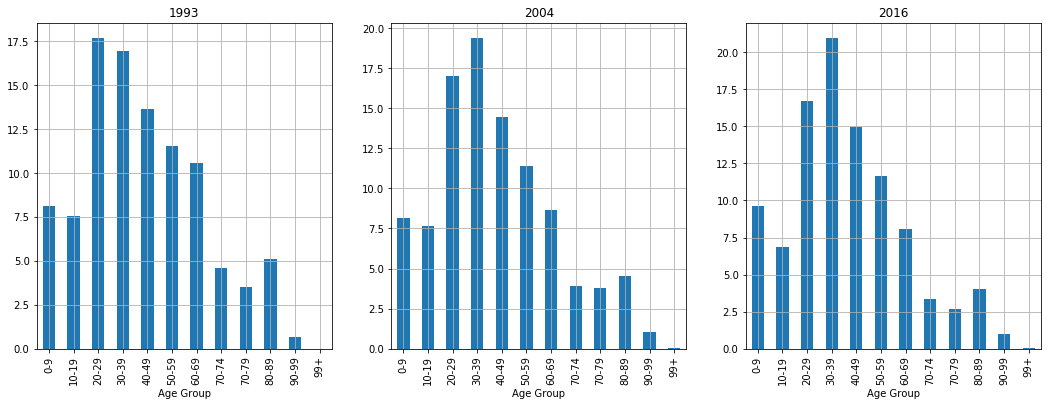

In [40]:

age_groups = ZH_popul

# Change the age intervall from a span of 5 years to 10 years.
age_groups = age_groups.replace(['0-4','5-9'], '0-9')
age_groups = age_groups.replace('5-9', '0-9')
age_groups = age_groups.replace('10-14', '10-19')
age_groups = age_groups.replace('15-19', '10-19')
age_groups = age_groups.replace('20-24', '20-29')
age_groups = age_groups.replace('25-29', '20-29')
age_groups = age_groups.replace('30-34', '30-39')
age_groups = age_groups.replace('35-39', '30-39')
age_groups = age_groups.replace('40-44', '40-49')
age_groups = age_groups.replace('45-49', '40-49')
age_groups = age_groups.replace('50-54', '50-59')
age_groups = age_groups.replace('55-59', '50-59')
age_groups = age_groups.replace('60-64', '60-69')
age_groups = age_groups.replace('65-69', '60-69')
age_groups = age_groups.replace('70-64', '70-79')
age_groups = age_groups.replace('75-79', '70-79')
age_groups = age_groups.replace('80-84', '80-89')
age_groups = age_groups.replace('85-89', '80-89')
age_groups = age_groups.replace('90-94', '90-99')
age_groups = age_groups.replace('95-99', '90-99')


age_groups = df_subset_percent(age_groups, 'Year', 'age_group5','Total')
age_groups = age_groups.rename(columns={"age_group5": "Age Group"})
# Age groups for 1993
age_groups_1993 = age_groups[age_groups['Year']==1993]
age_groups_1993 = age_groups_1993.set_index("Age Group")

# Age group for 2004
age_groups_2004 = age_groups[age_groups['Year']==2004]
age_groups_2004 = age_groups_2004.set_index("Age Group")

# Age group for 2016
age_groups_2016 = age_groups[age_groups['Year']==2016]
age_groups_2016 = age_groups_2016.set_index("Age Group")
# Plot bar plots for the distributions
fig, axes = plt.subplots(1, 3, figsize=(18,6))
age_groups_1993["Percent of age_group5"].plot.bar(ax=axes[0],y='Percent',x='Age Group', title='1993', grid=True)

age_groups_2004["Percent of age_group5"].plot.bar(ax=axes[1],y='Percent',x='Age Group', title='2004', grid=True)

age_groups_2016["Percent of age_group5"].plot.bar(ax=axes[2],y='Percent', x='Age Group',title='2016', grid=True)




## Map over where different age group move
In these map we compare the percentage of how many of the people moving to a certain district is from different age groups. The age groups are devided into children, age 0-19, young professionals, age 20-29, mid age professionals, age 30-39, senior professionals, age 40-59 and pensioners, age 60-99+. In this case we use the moving within data set.

In [41]:
# Finding the annual percentages for children, young professionals and seniors in the overall population
def age_group_year(year):
    #We use the moving within data
    a1 = df_subset_percent(ZH_within_df, ['Year', 'district_to_name'], 'age_group','Total')
    a = a1[a1['Year']==year]

    # Creat dataframe for children, age 0-19
    ZH_district_children_percent_1 =df_select_values(a, "age_group", ["0-9", "10-19"])
    ZH_district_children_percent =df_subset_total(ZH_district_children_percent_1, ["district_to_name"], "Percent of age_group")

    # Creat dataframe for young professionals, age 20-29
    ZH_district_youngprof_percent_1 =df_select_values(a, "age_group", ["20-29"])
    ZH_district_youngprof_percent =df_subset_total(ZH_district_youngprof_percent_1, ["district_to_name"], "Percent of age_group")

    # Creat dataframe for mid age professionals, age 30-39
    ZH_district_midprof_percent_1 =df_select_values(a, "age_group", ["30-39"])
    ZH_district_midprof_percent =df_subset_total(ZH_district_midprof_percent_1, ["district_to_name"], "Percent of age_group")
    # Creat dataframe for senior professionals, age 40-59
    ZH_district_seniorsprof_percent_1 = df_select_values(a, "age_group", ["40-49","50-59"])
    ZH_district_seniorsprof_percent =df_subset_total(ZH_district_seniorsprof_percent_1, ["district_to_name"], "Percent of age_group")
    # Creat dataframe for pensioners, age 60-99+
    ZH_district_pensioners_percent_1 =df_select_values(a, "age_group", ["60-69","70-79","80-89","90-99","99+"])
    ZH_district_pensioners_percent =df_subset_total(ZH_district_pensioners_percent_1, ["district_to_name"], "Percent of age_group")

    
    
    return [ZH_district_children_percent, ZH_district_youngprof_percent,ZH_district_midprof_percent,ZH_district_seniorsprof_percent,ZH_district_pensioners_percent]



In [42]:
#Function that plots the choropleth map
import folium
import branca.colormap as cms
from folium import plugins
from scipy.ndimage import imread
from IPython.display import display

def ploting_age(y) :
    [ZH_district_children_percent, ZH_district_youngprof_percent,ZH_district_midprof_percent,ZH_district_seniorsprof_percent,ZH_district_pensioners_percent] = age_group_year(y)
    zurich_geo_path = r'Data/ZH_district_geo.json'
    geo_json_data = json.load(open(zurich_geo_path))
    zh_map1 = folium.Map(location=[47.3769, 8.5417], zoom_start=12,tiles='cartodbpositron')
    zh_map2 = folium.Map(location=[47.3769, 8.5417], zoom_start=12,tiles='cartodbpositron')
    zh_map3 = folium.Map(location=[47.3769, 8.5417], zoom_start=12,tiles='cartodbpositron')
    threshold_scale = np.linspace(ZH_district_children_percent['Total'].min(),
                              ZH_district_children_percent['Total'].max(),
                              10, dtype=int)
    threshold_scale1 = threshold_scale.tolist()
    
    zh_map1.choropleth(geo_data=geo_json_data, data=ZH_district_children_percent,
             name="Children", 
             columns=['district_to_name','Total'],
             key_on='feature.properties.qname',
             fill_color='YlGnBu',
             #threshold_scale = threshold_scale1,
             legend_name='Percentage of children moving to a district compare to overall movement'
                     )

    
    zh_map2.choropleth(geo_data=geo_json_data, data=ZH_district_youngprof_percent,
             name = 'Young professionals',
             columns=['district_to_name','Total'],
             key_on='feature.properties.qname',
             fill_color='YlGnBu',
             legend_name='Percentage of young professionals moving to a district compared to overall movement'
             #legend_name='Percentage of moving in compared to district population'
                     )
    zh_map2.choropleth(geo_data=geo_json_data, data=ZH_district_midprof_percent,
             name = 'Mid age professionals',
             columns=['district_to_name','Total'],
             key_on='feature.properties.qname',
             fill_color='YlGnBu',
             legend_name='Percentage of mid age professionals moving to a district compared to overall movement'
             #legend_name='Percentage of moving in compared to district population'
                     )
    
    zh_map3.choropleth(geo_data=geo_json_data, data=ZH_district_seniorsprof_percent,
             name = 'Senior professionals',
             columns=['district_to_name','Total'],
             key_on='feature.properties.qname',
             fill_color='YlGnBu',
             legend_name='Percentage of senior professionals moving to a district compared to overall movement'
             #legend_name='Percentage of moving in compared to district population'
                     )
    
    zh_map3.choropleth(geo_data=geo_json_data, data=ZH_district_pensioners_percent,
             columns=['district_to_name','Total'],
             key_on='feature.properties.qname',
             fill_color='YlGnBu',
             legend_name='Percentage of pensioners moving to a district compared to overall movement'
             #legend_name='Percentage of moving in compared to district population'
                     )
    
    
    folium.LayerControl().add_to(zh_map2)
    folium.LayerControl().add_to(zh_map3)
    # display the content on function call
    display(zh_map1)
    display(zh_map2)
    display(zh_map3)

In [43]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from ipywidgets import IntSlider
# Creat a slider widget for changeing the year
#Interact calls the ploting function with the widget values and plots the new map
interact(ploting_age, y = widgets.IntSlider(min=1993, max=2016,step=1))



A Jupyter Widget

<function __main__.ploting_age>

## Map female/male

In [44]:
 def year_f_m(y):
    
    ZH_district_gender_percent = df_subset_percent(ZH_in_df, ['Year', 'district_to_name'], 'gender', 'Total')
    # Select females
    ZH_district_Female_percent =ZH_district_gender_percent[ZH_district_gender_percent['gender']=="F"]
    #Select year
    ZH_district_Female_percent_year =ZH_district_Female_percent[ZH_district_Female_percent['Year']==y]
    # Select males
    ZH_district_male_percent =ZH_district_gender_percent[ZH_district_gender_percent['gender']=="M"]
    #Select year
    ZH_district_male_percent_year =ZH_district_male_percent[ZH_district_male_percent['Year']==y]
    return [ZH_district_Female_percent_year,ZH_district_male_percent_year]

In [45]:
#Function that plots the choropleth map
import folium
import branca.colormap as cms
from folium import plugins
from IPython.display import display

def ploting_gender(y) :
    [ZH_district_Female_percent_year,ZH_district_male_percent_year] = year_f_m(y);
    zurich_geo_path = r'Data/ZH_district_geo.json'
    geo_json_data = json.load(open(zurich_geo_path))
    zh_map = folium.Map(location=[47.3769, 8.5417], zoom_start=12,tiles='cartodbpositron')
    
    
    zh_map.choropleth(geo_data=geo_json_data, data=ZH_district_Female_percent_year,
             name = 'Female',
             columns=['district_to_name',"Percent of gender"],
             key_on='feature.properties.qname',
             fill_color='YlGnBu',
             #threshold_scale = threshold_scale1,
             legend_name='Percentage of females moving in compared to overall movement'
                     )
    
    zh_map.choropleth(geo_data=geo_json_data, data=ZH_district_male_percent_year,
             name = 'Male',
             columns=['district_to_name',"Percent of gender"],
             key_on='feature.properties.qname',
             fill_color='YlGnBu',
             legend_name='Percentage of males moving in compared to overall movement')
    folium.LayerControl().add_to(zh_map)
    # display the content on function call
    display(zh_map)



In [46]:
# Creat a slider widget for changeing the year

#Interact calls the ploting function with the widget values and plots the new map
interact(ploting_gender, y = widgets.IntSlider(min=1993, max=2016,step=1))

A Jupyter Widget

<function __main__.ploting_gender>

## Map single/married

In [47]:
 def year_s_m(y):
    ZH_district_gender_percent = df_subset_percent(ZH_in_df, ['Year', 'district_to_name'], 'marital_status', 'Total')
    # Select females
    ZH_district_single_percent =ZH_district_gender_percent[ZH_district_gender_percent['marital_status']=="Single"]
    #Select year
    ZH_district_single_percent_year =ZH_district_single_percent[ZH_district_single_percent['Year']==y]
    # Select males
    ZH_district_married_percent =ZH_district_gender_percent[ZH_district_gender_percent['marital_status']=="Married"]
    #Select year
    ZH_district_married_percent_year =ZH_district_married_percent[ZH_district_married_percent['Year']==y]
    return [ZH_district_single_percent_year,ZH_district_married_percent_year]

In [48]:
#Function that plots the choropleth map
import folium
import branca.colormap as cms
from folium import plugins
from IPython.display import display

def ploting_marital_status(y) :
    [ZH_district_single_percent_year,ZH_district_married_percent_year] = year_s_m(y);
    zurich_geo_path = r'Data/ZH_district_geo.json'
    geo_json_data = json.load(open(zurich_geo_path))
    zh_map = folium.Map(location=[47.3769, 8.5417], zoom_start=12,tiles='cartodbpositron')

    zh_map.choropleth(geo_data=geo_json_data, data=ZH_district_single_percent_year,
             name = 'Single',
             columns=['district_to_name',"Percent of marital_status"],
             key_on='feature.properties.qname',
             fill_color='RdYlBu',
             #threshold_scale = threshold_scale1,
             legend_name='Percentage of single moving in compared to overall movement between single and married'
                     )
    
    zh_map.choropleth(geo_data=geo_json_data, data=ZH_district_married_percent_year,
             name = 'Married',
             columns=['district_to_name',"Percent of marital_status"],
             key_on='feature.properties.qname',
             fill_color='RdYlBu',
             legend_name='Percentage of married moving in compared to overall movement between single and married'
             #legend_name='Percentage of male moving in compared to district population'
                     )
    folium.LayerControl().add_to(zh_map)
    # display the content on function call
    display(zh_map)

In [49]:
y = 1997
# Creat a slider widget for changeing the year

#Interact calls the ploting function with the widget values and plots the new map
interact(ploting_marital_status, y = widgets.IntSlider(min=1993, max=2016,step=1))

A Jupyter Widget

<function __main__.ploting_marital_status>

## Storyline

#### The idea 
In 1993, you are just 18, you move to Zurich. Your plan for the next 25 years is:

1) Study/work in Zurich,  2) get married at the age of 26,   3) have children at the age of 30.

How do these decisions influence where you will live, when you will move or even leave Zurich? 

### Implementation

Our simulation is more general by allowing you to specify personal information (PI) and your lifeplan. It then creates a path according to these. 

#### Initial personal information

To start your storyline you specify the year you move to Zurich, your age, gender and matital status at the time.

#### Your lifeplan
You also decide on some key parameters on your life: 

1) **When are you getting married?** - At this point your marital status changes. Your moving pattern will differ from that of singles.

2) **When are you getting a family?** - When you have children they influence your decisions. In order to distinguish between your family and a couple (or single) without children, we don't track you but instead your child. Hence we change age and gender to those of the your child and set the marital status to 'Single'. Once your child is 18, we return to your parameters.

3) **What is the minimum time that you plan to live in Zurich?** - This function allows us to generate some interesting path by limiting the chances that you will leave Zurich too soon. (Chances for leaving are actually high.)

#### Running the simulation

The simulations subsets the dataframe according to the current PI and makes a probabilisitc decision based on this subgroup. 

The storyline is created as follows:

1) Your initial district is generated.

2) At the start of the year your PI is regularly updated according to your life plan. You then decide whether to stay, move iside Zurich or leave Zurich altogether (if your parameters allow you to). Your new district is then chosen accordingly.

3) The details of your PI, your decisions and your moves can be recorded.

Remark: Data does not distinguish whether people have children or not. Therefore we track a family through the children until they are 18 and assumed to leave the house.

**(Almost) 1001 storylines**

In a second step we run a 1000 storylines and collect where you would live in 2017. We consider to scenarios:

a) A young woman moves to Zurich for her undergraduate studies, finds a job, falls in love, marries and has a family. 

Initial parameters: (Year=1993, age=18, gender='F', marital status='Single', married_age=26, family_age=30, minimum_years=13)

b) A couple moves to Zurich to start a family.

Initial parameters: (Year=1993, age=29, gender='M', marital status='Married', married_age=26, family_age=30, minimum_years=10)







### Functions used for the storyline

#### Help functions

Help functions to generate age group codes and to subset dataframes according to specific parameter choices. 
These are given below:

In [51]:
# Turn age into the correct age_group_code 

def age_gp_code(age):
    age_group_code=math.floor((age/10)+1)
    return age_group_code


#-------------------------------------------------------------------------------------------------------------
# Functions that automate selecting specific subsets from the dataframe:
# Subset on AGM
def df_subset_AGM(df, Age_group_code, Gender, Marital_status):
    df = df[df['age_group_code']==Age_group_code]
    df = df[df['gender']==Gender]
    df = df[df['marital_status']==Marital_status]
    output = df
    return output;


#-------------------------------------------------------------------------------------------------------------
# Subset on YAG
def df_subset_YAG(df, Year, Age_group_code, Gender):
    df = df[df['age_group_code']==Age_group_code]
    df = df[df['gender']==Gender]
    df = df[df['Year']==Year]
    output = df
    return output;


#-------------------------------------------------------------------------------------------------------------
# Subset on YAG using 5 year bins for age (needed for population dataframe)
def df_subset_YA5G(df, Year, Age_group_code, Gender):
    df = df[df['age_group5_code']==Age_group_code]
    df = df[df['gender']==Gender]
    df = df[df['Year']==Year]
    output = df
    return output;


#-------------------------------------------------------------------------------------------------------------
# Subset on YAGM
def df_subset_YAGM(df, Year, Age_group_code, Gender, Marital_status):
    df=df_subset_YAG(df, Year, Age_group_code, Gender)
    df = df[df['marital_status']==Marital_status]
    output = df
    return output;


#-------------------------------------------------------------------------------------------------------------
# Subset on YAGD
def df_subset_YAGD(df, Year, Age_group_code, Gender, District):
    df=df_subset_YAG(df, Year, Age_group_code, Gender)
    df = df[df['district_from_name']==District]
    output = df
    return output;



### Main functions

**create_init_param(user_YAGMD)**: takes the start values for YAGMD provided by the user and creates the initial parameters needed for the simulation

In [52]:
# Convert start parameters into initial parameters
def create_init_param(user_YAGMD):
    (start_year, start_age, start_gender, start_marital_status, start_district) = user_YAGMD
    global child_status
    global leave_option

### Age
    age=start_age
### Marriage
    marital_status = start_marital_status
    if married_age<= start_age:
        marital_status = 'Married' # we override your input of being single and treat you as married
    # print('We assume that when you move to Zurich you are already married')

### Family / Children
    gender = start_gender
# Considering the case that you move with a family/child to ZH
    if family_age<=start_age: # equality means child just born and age=0
        # print('When you move to Zurich you are already had a family and a child')
        child_status = True
        # Calculate age of the child
        age=start_age-family_age
        # Change gender to be tracked by that of the child
        gender = gender_child
    init_param = (start_year, age, gender, marital_status, start_district)
    return init_param



#### The first move

As you move to Zurich you have to decide where to move to. 

**ZH_in_district_gen(YAGMD)**: use the values from **create_init_param(user_YAGMD)** to generate the first district you live in

In [53]:
# Probabilistic district generators:
# Our probability distributions are influenced by 5 factors: YAGMD
# Y=year, A=age group (10yr), G=gender, M=marital status, D=current district
# Below dataframes will be subset according to the YAGMD parameters

def ZH_in_district_gen(YAGMD):
    (year, age, gender, marital_status,district)=YAGMD
    # calculate age_code first
    age_group_code = age_gp_code(age)
    ZH_in_YAGM=df_subset_YAGM(ZH_in_df, year, age_group_code, gender, marital_status)
    # Create total count for each district with YAGM
    ZH_in_YAGM_district_total=df_subset_total(ZH_in_YAGM, 'district_to_name', 'Total')
    # Create ZH total count with YAGM - one number
    ZH_in_YAGM_count=ZH_in_YAGM_district_total.agg({'Total': 'sum'})
    #print((ZH_in_YAGM_count))
    # Create district vector
    district_list=ZH_in_YAGM_district_total['district_to_name']
    # Create probabilities (percentages) for each district with YAGM
    # need to deal with column being represented as a series for division (use for loop) 
    # and want quotients returned as single floats not lists or tuples
    probability_list=[float(x/ZH_in_YAGM_count) for x in ZH_in_YAGM_district_total['Total']]
    #print(probability_vect)
    # Generate random choice and transform outcome to a string
    # If we do not use [0] to extract single element fomr the list, 
    # then use [2:-2] to cut off [' and '] from the string
    newdistrict = str((np.random.choice(district_list, 1, p=probability_list) )[0])
    next_YAGMD=(year, age, gender, marital_status,newdistrict)
    return next_YAGMD

While generating the storyling we need to regularly update the PI (YAGMD). 

**update(YAGMD)**: Update latest YAGMD (generated in previous cycle) against our lifeplan then return the updated YAGMD    

In [54]:
# Function: update_YAGMD(YAGMD)
# At the start of each loop we update YAGMD against our lifeplan - remember YAGMD is returned as a tuple 
# Return the updated YAGMD    
    
def update_YAGMD(YAGMD):
    global child_status
    global leave_option
    (year, age, gender, marital_status, district)=YAGMD
    year = year +1 #update year. 
    age = age + 1 # update age
    if age==married_age: # this cannot happen in child setting as age<18
        marital_status='Married'  
    if minimum_years<year-start_year:
        leave_option = True
    
    # When you start a family, you can be tracked through your kids
    # Check age and then change parameters to those of the child (0<=age<18)  
    if age==family_age:
        child_status = True
        age=0 # reset age
        gender=gender_child # reset gender
        marital_status='Single' #Note if married_age==family_age then this overrides 'Married'
    
    # When the child turns 18 (so age=18), you return to the parents' track. So reset age and marital_status
    if (age==18 and child_status == True):
        child_status = False
        age=year-start_year+start_age # reset age
        gender=start_gender # reset gender
        if age>=married_age:
            marital_status='Married'
    
    updated_YAGMD=(year, age, gender, marital_status, district)
    return updated_YAGMD
    

Below we define the 3 functions used to make the decision of staying, moving or leaving: 

1) **ZH_popul_YAGD_count(YAGMD)**:  to calculate the number of people living in your current district and fitting your YAGMD-parameter.

2) **ZH_within_YAGD_count(YAGMD)**:  to calculate the number of people living in your current district, fitting your YAGMD-parameter who decided to move withing Zurich.

3) **ZH_out_YAGD_count(YAGMD)**:  to calculate the number of people living in your current district, fitting your YAGMD-parameter who decided to leave Zurich.

In [55]:
# Once in ZH we are met with 3 options: 1) stay where we are, 2) moving within ZH, 3) leave ZH
# For the probability distribution we need for year Y
# 1) total number of AGM living in current district, 
# 2) total of AGM moving within ZH from the current district D, 
# 3) total of AGM leaving ZH from the current district D

def ZH_popul_YAGD_count(YAGMD):
    (year, age, gender, marital_status, district)=YAGMD
    age_group_code = age_gp_code(age)
    # Calculate total population in the district for 10yr groups 
    # Ignoring marital status! here - note that it is actually irrelevant while we are tracking children
    age_group5_code1 = age_group_code*2-1
    age_group5_code2 = age_group_code*2
    # We create a frame for each subgroup and then take the total numbers
    ZH_popul_YAG1 = df_subset_YA5G(ZH_popul, year, age_group5_code1, gender)
    ZH_popul_YAGD1 = ZH_popul_YAG1[ZH_popul_YAG1['district_name']==district]
    ZH_popul_YAGD1_count = ZH_popul_YAGD1.agg({'Total': 'sum'})
    #
    ZH_popul_YAG2 = df_subset_YA5G(ZH_popul, year, age_group5_code2, gender)
    ZH_popul_YAGD2 = ZH_popul_YAG2[ZH_popul_YAG2['district_name']==district]
    ZH_popul_YAGD2_count = ZH_popul_YAGD2.agg({'Total': 'sum'})
    # Add totals
    output = ZH_popul_YAGD1_count + ZH_popul_YAGD2_count
    return output


-------------------------------------------------------------------------------------------------------------
def ZH_within_YAGD_count(YAGMD):
    (year, age, gender, marital_status, district)=YAGMD
    age_group_code = age_gp_code(age)
    # Calculate the total number of YAG moving away from a district (ignoring marital status)
    # Extract subset dataframe
    ZH_within_YAG=df_subset_YAG(ZH_within_df, year, age_group_code, gender)
    # Create total count for each district with YAG
    ZH_within_YAG_district_total=df_subset_total(ZH_within_YAG, 'district_from_name', 'Total')
    # Select YAG total for given district
    output_row=ZH_within_YAG_district_total[ZH_within_YAG_district_total['district_from_name']==district]
    output=output_row['Total']
    if len(output)==0:
        #print(output,'empty within')
        output= pd.Series([0])
    return output


-------------------------------------------------------------------------------------------------------------
def ZH_out_YAGD_count(YAGMD):
    (year, age, gender, marital_status, district)=YAGMD
    age_group_code = age_gp_code(age)
    # Calculate the total number of YAG moving away from a district (ignoring marital status)
    # Extract subset dataframe
    ZH_out_YAG=df_subset_YAG(ZH_out_df, year, age_group_code, gender)
    # Create total count for each district with YAG
    ZH_out_YAG_district_total=df_subset_total(ZH_out_YAG, 'district_from_name', 'Total')
    # Select YAG total for given district
    output_row=ZH_out_YAG_district_total[ZH_out_YAG_district_total['district_from_name']==district]
    output=output_row['Total']
    if len(output)==0:
        #print(output,'empty out')
        output= pd.Series([0])
    return output

SyntaxError: invalid syntax (<ipython-input-55-f45791784337>, line 27)

#### Decision function:

When you live in Zurich you have to decide whether to a) stay in your place, b) move inside Zurich or c) leave Zurich altogether. 

We do this by generating a probability distribution that compares the number of people fitting the YAGMD-parameter and decided on a), b) or c). From this probability distribution we generate the decision.

Since the population data for Zurich does not track the marital status of people we can not use this parameter to subset the population. Hence we ignore the marital status and only use YAGD for subsetting.

**decision(YAGMD)**:  to generate a random choice from a), b) or c) according to the numbers calculated by functions in the section above 1), 2) and 3).

In [ ]:
def decision(YAGMD):
    if YAGMD[4]=='outside':
        #return 'You left ZH, remember!?!'
        return 'leave'
    elif YAGMD[4]=='None':
        return 'You first have to move into ZH'
    else:
        option_list=['stay', 'move within', 'leave']
        overall=int(ZH_popul_YAGD_count(YAGMD))
        move_within = int(ZH_within_YAGD_count(YAGMD))
        leavers = int(ZH_out_YAGD_count(YAGMD))
        
        
          
        #Problem: For certain subsets and districts there is such a high turnover that combined
        # we have more movers and leavers than the overall population. As a result the number of people staying
        # would be negative and as a result so would be the probabilities we wish to use. ---> Error 
        # Warning call
        #if move_within+leavers>=overall:
            # print('Warning: for ',YAGMD, '  ',overall,' < ', move_within, ' or ', leavers,', staying ', overall- move_within -leavers)
        
        # The above problem may arise because people only spend a few months and thus do not get counted as 
        # residents in the population, but contribute to movers and leavers.
        # To counteract this we treat the population as stayers.
        # This is an adhoc solution, to avoid throwing up an error on the probabilities
        # and to avoid an unreasonably low chance of staying in the district.
        if (move_within + leavers)/overall > 0.8: # i.e. if sum makes up over 80% of overall
            #print('take evasive action')
            staying = overall
            # redefine the overall value
            overall = staying + move_within + leavers
        else:
            # Uncomment section below if we want to use leave_option 
            # to avoid leavers influencing the probability distribution for the random choice
            if leave_option == False:
                # The above prevents us from leaving, hence we only decide between moving and staying
                overall=overall-leavers #positive as leavers<overall
                leavers=0
            staying = overall- move_within -leavers #positive as movers+leavers<overall


        decision_list=[staying , move_within, leavers]
        probability_list=[float(x/overall) for x in decision_list]

        # Test loop 1 and error tracing:
        for n in range(0,3):
            if probability_list[n]<0:
                print('Problem: negative probability', probability_list)
                print(probability_list, overall, move_within, leavers, YAGMD)
        
        if probability_list[0]+probability_list[1]+probability_list[2] !=1:
            # print('correcting overall prob sum', probability_list)
            probability_list[2]=1-probability_list[0]-probability_list[1]
            # print('Corrected version:', probability_list)
        
        # Note we get single element list, so extract with [0]
        # get numpy.str so use str to make sure we have str(ing)
        decision = str((np.random.choice(option_list, 1, p=probability_list) )[0])
        # For debugging and testing we return probability_list 
        return decision
    

Once the decision has been made we need to act upon it and create the new YAGMD

**next_year(YAGMD)**: Given the decision(YAGMD), check whether it fits our plan then
act upon the decision and create next_YAGMD . 

If we have not passed the minimum number of years we override the decision to leave.

In [ ]:
#Function: next_year(YAGMD)
# Create the YAGMD for next year as follows:
# Decide whether to move, leave or not using the decision(YAGMD) function
# Act upon the decision and create next_YAGMD with the outcome accordingly

def next_year(YAGMD):
    global initial_decision
    global current_decision

    initial_decision = decision(YAGMD)
    
    if initial_decision == 'move within': 
        next_YAGMD=ZH_within_district_gen(YAGMD)
        next_district=next_YAGMD[4]
        current_decision = 'move within'
        
    elif initial_decision == 'leave':
        # Check that minimum years have passed yet, i.e. that leave_option = True 
        if leave_option == False:
        #Option 1: You have that leaving feeling but you cannot leave yet, so you decide to move within ZH :
#             next_YAGMD=ZH_within_district_gen(YAGMD)
#             next_district=next_YAGMD[4]
#             YAGMD=next_YAGMD
#             current_decision = 'move within'
        #Option 2: You suck it up and you stay where you are:
            next_district = YAGMD[4]
            current_decision = 'must stay'
        if leave_option == True:
            current_decision = 'leave'
            next_district= 'outside'
        # YAGMD is a tuple, so convert to list, amend and reconvert to tuple
        YAGMD_list=list(YAGMD)
        YAGMD_list[4]=next_district
        next_YAGMD=tuple(YAGMD_list)
        
    else: 
        #case of decision =stay:
        current_decision = 'stay'
        #keep YAGMD aka do nothing
        next_YAGMD=YAGMD
        next_district = YAGMD[4]
    
    return next_YAGMD

#### Main function to generate the storyline

In [ ]:
# When record=False then only the final district is recorded
# When record=True then we record each years YAGMD plus the decisions

def generate_storyline(user_start_year, 
                       user_start_age, 
                       user_start_gender, 
                       user_start_marital_status, 
                       #start_district, 
                       user_married_age, 
                       user_family_age, 
                       user_minimum_years,
                       record):
    global child_status
    global leave_option
    global married_age
    global family_age
    global minimum_years
    global start_year
    global start_age 
    global start_gender
    global start_marital_status
    global gender_child
    # Defining further parameters
    start_year = user_start_year
    start_age = user_start_age
    start_gender = user_start_gender
    start_marital_status = user_start_marital_status
    married_age = user_married_age
    family_age = user_family_age
    minimum_years = user_minimum_years
    
    start_district = 'None'
    user_YAGMD=(start_year, start_age, start_gender, start_marital_status, start_district)
    life_plan = (married_age, family_age, minimum_years)
#    print(user_YAGMD)
#    print(life_plan)
    ### Child
    # For simplicity we work with the assumption that you have one child.
    # child_status indicates that you have a child under 18. 
    # When child_status=False we track you, the parent. 
    # When child_option=True we track your child.
    # Initial assumption you have no child yet - if otherwise this gets updated later
    child_status = False
    # Generating the gender of your child randomly
    gender_child = str((np.random.choice(['M','F'], 1, p=[0.5,0.5]) )[0])
#    print('start_gender', start_gender,'    ', 'gender_child', gender_child)
    
    ### Minimum stay and leave_option
    # leave_option checks whether the minimum years for staying in ZH have passed. 
    # When leave_option=True then you can consider leaving, when leave_option=False you cannot leave ZH. 
    # Initialize leave_option 
    leave_option = True
    if minimum_years>0:
        leave_option = False

    # Record keeping
    # Create lists to track outputs, statuses, decisions and the districts in which you live.
    my_records=list()

    # Create the initial parameters for the storyline
    init_param = create_init_param(user_YAGMD)
    
    # Moving into Zurich - generating the first district in which you live
    YAGMD=ZH_in_district_gen(init_param)
#    print('gender',YAGMD[2])
    
    # Update records
    if record==True:
        # Create record
        YAGMD_list=list(YAGMD)
        first_record=list(['move to ZH', 'move to ZH'])
        first_record.extend(YAGMD_list)
        first_record.extend([leave_option, child_status] )
        # Update list
        my_records=[first_record]
    #endif
#    print(my_records)
    #Generate timeline
    for y in range(YAGMD[0]+1,2017): #Note y is used inside update_YAGMD(YAGMD) as the current year
        # STEP 1
        # At the start of each loop we update YAGMD against our lifeplan - remember YAGMD is returned as a tuple 
        # Return the updated YAGMD

        updated_YAGMD=update_YAGMD(YAGMD)

        # STEP 2
        # Create the YAGMD for next year as follows:
        # This includes the decision whether to move, leave or not; acting upon the decision 
        # and creating next_YAGMD with the outcome accordingly

        YAGMD = next_year(updated_YAGMD)

        # STEP 5
        # Update my records
        if record==True:
            # Build new record
            YAGMD_list=list(YAGMD)
            new_record=list([initial_decision, current_decision])
            new_record.extend(YAGMD_list)
            new_record.extend([leave_option, child_status] )
            # Add new record to my_records
            my_records.append(new_record)
        #endif
        if record==False and y==2016:
            YAGMD_list=list(YAGMD)
            final_district=YAGMD_list[4]
            # print(final_district)
            my_records=[final_district]
    #endloop
    
    return my_records

### Generating a single storyline

In [ ]:
# For a storyline set record to True (get detailed annual info)
my_records = generate_storyline(1993, 18, 'F', 'Single', 26, 30, 13, True)

storyline = pd.DataFrame(my_records, columns=['initial decision', 'final decision', 
                                              #'P(staying)', 'P(movers)', 'P(leavers)', 
                                              'year', 'age', 'gender', 'marital_status', 'district', 
                                              'leave_option', 'child_status'])
storyline

#storyline.to_csv('samplestoryline2.csv', encoding='utf-8', index = False)

### Iterations (code run once then commented out)

Since the iterations were calculation intensify we have run them once and saved the output externally. The code ahs been commented out and the data has been read from teh external files.

a) A young woman moves to Zurich for her undergraduate studies, finds a job, falls in love, marries and has a family. 

Initial parameters: (Year=1993, age=18, gender='F', marital status='Single', married_age=26, family_age=30, minimum_years=13)

In [ ]:
# # For an iteration set record to False (only get final disrict)
# iteration_list=list()
# for n in range(0,1000):
#     # Version a)
#     my_records = generate_storyline(1993, 18, 'F', 'Single', 26, 30, 13, False)
#     iteration_list.append(my_records)
# #     if n%20==0:
# #         print(n)

# final_district_1000a = pd.DataFrame(iteration_list, columns=['last district'])
# final_district_1000a.to_csv('storyline_iteration_1000a.csv', encoding='utf-8', index = False)

# final_district_1000a.describe()

b) A couple moves to Zurich to start a family.

Initial parameters: (Year=1993, age=29, gender='M', marital status='Married', married_age=26, family_age=30, minimum_years=10)

In [ ]:
# # For an iteration set record to False (only get final disrict)
# iteration_list=list()
# for n in range(0,1000):
#     # Version b)
#     my_records = generate_storyline(1994, 30, 'M', 'Married', 26, 31, 10, False)
#     iteration_list.append(my_records)

# final_district_1000b = pd.DataFrame(iteration_list, columns=['last district'])
# final_district_1000b.to_csv('storyline_iteration_1000b.csv', encoding='utf-8', index = False)

# final_district_1000b.describe()

#### Comparing the two iterations

In [ ]:
final_district_1000a=pd.read_csv('storyline_iteration_1000a.csv')
final_district_1000a=final_district_1000a.rename(columns={"last district" : 'Scenario_A'})
Scenario_a=final_district_1000a.apply(pd.value_counts).fillna(0)

final_district_1000b=pd.read_csv('storyline_iteration_1000b.csv')
final_district_1000b=final_district_1000b.rename(columns={'last district' : 'Scenario_B'})
Scenario_b=final_district_1000b.apply(pd.value_counts).fillna(0)


In [ ]:
Comparison=Scenario_a.join(Scenario_b)
Comparison['Difference']=Comparison['Scenario_A']-Comparison['Scenario_B']
Comparison=Comparison.reset_index()
Comparison.rename(columns={'index': 'district'}, inplace=True)

# Dropping the row for moving outside of Zurich
Comparison=Comparison.drop([0])
Comparison

In [ ]:
def comparison_color(district):
    if district == 'City' or district == 'Hochschulen' or district=='Lindenhof':
        return '#0b0b0c'
    diff = Comparison.loc[Comparison['district'] == district, 'Difference'].values[0]
    if diff <= -7:
        return '#ff0000'
    elif diff <= -3:
        return '#f78080'
    elif diff <3:
        return '#ffffff'
    elif diff <7:
        return '#148be0'
    else:
        return '#011399'

In [ ]:
zurich_geo_path = r'Data/ZH_district_geo.json'
geo_json_data = json.load(open(zurich_geo_path))
zh_map = folium.Map(location=[47.3769, 8.5417], zoom_start=12,tiles='cartodbpositron')
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': comparison_color(feature['properties']['qname']),
        'color' : 'black',
        'weight' : 2,
        }
    ).add_to(zh_map)
zh_map

## District to district (D2D) analysis of people moving within

We calculate the total number of moves between pairs of districts and plot these in a grid.

We use the district codes, as these are automatically ordered by Kreis from inner district to outer. 

In [ ]:
# Using district names
d2d = df_subset_total(ZH_within_df, ['Year', 'district_from_name', 'district_to_name'], 'Total')
d2d_from = df_subset_total(ZH_within_df, ['Year', 'district_from_name'], 'Total')
d2d_to = df_subset_total(ZH_within_df, ['Year', 'district_to_name'], 'Total')

# Using district codes
# Annual total numbers of people moving from district X to Y
d2dc = df_subset_total(ZH_within_df, ['Year', 'district_from_code', 'district_to_code'], 'Total')
# Annual total numbers of people moving from district X
d2dc_from = df_subset_total(ZH_within_df, ['Year', 'district_from_code'], 'Total')
# Annual total numbers of people moving to district Y
d2dc_to = df_subset_total(ZH_within_df, ['Year', 'district_to_code'], 'Total')


In [ ]:
year=1993
d2dc_year = df_select_values(d2dc, 'Year', (year,))
d2dc_year_log = d2dc_year[d2dc_year['Total']!=0]
d2dc_year_log['log-Total']=np.log10(d2dc_year_log.Total)
d2dc_year_log=d2dc_year_log.drop(['Total'],1)
tablec_log = d2dc_year_log.pivot(values='log-Total', index='district_to_code',columns='district_from_code')
# Replace NaN by 0
tablec_log.fillna(0)

plt.imshow(tablec_log);
plt.colorbar()
plt.xlabel('original district')
plt.ylabel('destination district')
plt.title('order of magnitude for d2d movements')
plt.show()

In [ ]:
year=2005
d2dc_year = df_select_values(d2dc, 'Year', (year,))
d2dc_year_log = d2dc_year[d2dc_year['Total']!=0]
d2dc_year_log['log-Total']=np.log10(d2dc_year_log.Total)
d2dc_year_log=d2dc_year_log.drop(['Total'],1)
tablec_log = d2dc_year_log.pivot(values='log-Total', index='district_to_code',columns='district_from_code')
# Replace NaN by 0
tablec_log.fillna(0)

plt.imshow(tablec_log);
plt.colorbar()
plt.xlabel('original district')
plt.ylabel('destination district')
plt.title('order of magnitude for d2d movements')
plt.show()

In [ ]:
year=2016
d2dc_year = df_select_values(d2dc, 'Year', (year,))
d2dc_year_log = d2dc_year[d2dc_year['Total']!=0]
d2dc_year_log['log-Total']=np.log10(d2dc_year_log.Total)
d2dc_year_log=d2dc_year_log.drop(['Total'],1)
tablec_log = d2dc_year_log.pivot(values='log-Total', index='district_to_code',columns='district_from_code')
# Replace NaN by 0
tablec_log.fillna(0)

plt.imshow(tablec_log);
plt.colorbar()
plt.xlabel('original district')
plt.ylabel('destination district')
plt.title('order of magnitude for d2d movements')
plt.show()

When we look at the data on a district to district basis then we can see that regardless of size people most often move within their home district. 

Beyond that moves most often involve Kreis 3 to 6 or 10, 11 and 12.